# Swarm simulator

## Introduction

This notebook introduces a new swarm simulator. A key objective is to develop an efficient simulator using the Numpy library. The ideas behind the simulator are introduced gradually and illustrated by plotting the results using Matplotlib. Some boiler-plate code is introduced to assist with the computations and plotting.

In [46]:
"""
Some boiler-plate and functions to assist with plotting and animation
"""
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rc('font', family='serif', size=4)
plt.rc('figure', dpi=200)
plt.rc('axes', axisbelow=True, titlesize=5)
plt.rc('lines', linewidth=1)
plt.rcParams.update({'figure.max_open_warning': 0})
from matplotlib.animation import FuncAnimation
import numpy as np

def mk_vplot(grid=10, grid_interval=2, *, figsize=(3,3)):
    '''
    Create a figure with a grid for plotting vectors
    
    :param grid: an int giving the minimum boundaries of the grid  - 2 * grid x 2 * grid
    :param grid_interval: an int giving spacing between grid lines
    :param figsize: tuple giving the size of the figure that will be created
    '''
    fig, ax = plt.subplots(figsize=figsize)
    limit = grid + (grid % grid_interval) 
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    ax.set_aspect('equal')
    ticks = list(range(-limit, limit+1, grid_interval))
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.grid(True, linewidth=0.5, alpha=0.8)
    return fig, ax

def plot_vector(vectors, tails=None, *, colors='black', ax=None):
    '''
    Plot an array of vectors
    
    :param vectors: numpy array of shape (N,2) specifying N vectors
    :param tails: numpy array of shape (N,2) giving locations of tails for N vectors
    :param colors: either a string giving a color name or a list of size N of color names for vectors
    :param ax: the axes on which to plot the vectors - if None then plot on current axes
    '''
    if tails is None:
        tails = np.zeros_like(vectors)      # assume tails at the origin if not specified otherwise
    vectors_x = vectors[:,0]
    vectors_y = vectors[:,1]
    tails_x = tails[:,0]
    tails_y = tails[:,1]
    quiver_params = {'angles': 'xy',
                     'scale_units': 'xy',
                     'scale': 1,
                     'width': 0.005}
    if ax is None:
        ax = plt.gca()                     # assume plot on the current axes if not specified otherwise
 
    ax.quiver(tails_x, tails_y, vectors_x, vectors_y, color=colors, **quiver_params) # plot the vectors

A swarm comprises a set of *agents*. Each agent is defined by a number of *attributes*, including position, cohesion field, repulsion field, etc. Agent attributes will be introduced as we go along.

The principal attribute of an agent is its position in 2-D Euclidean space. We can specify an agent's position as a point, using the usual Cartesian coordinates or, equivalently, as a vector whose tail is located at the origin. For convenience and efficiency of use with Numpy, we model an agent's position as a column vector. For example, a swarm comprising a single agent, `b0`,
having an x-coordinate of 3 and a y-coordinate of 2 can be modelled as a column vector of shape (2,1), in which row 0 gives the x-coordinate, and row 1 the y-coordinate, of the single agent `b0` in column 0.

<IPython.core.display.Javascript object>


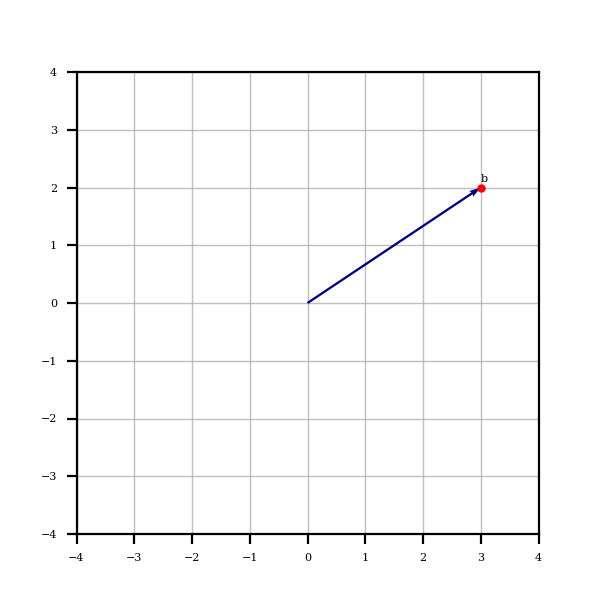

Text(3, 2.1, 'b')

In [47]:
"""
Show an agent at position (3,2) as a vector and as a point.

Note plot_vector expects a list of points as its first argument
and draws vectors to all of them
"""
b = np.array([
    [3],             # x-coordinate
    [2]              # y-coordinate
]) 
mk_vplot(4,1)
plot_vector(b.T, colors='darkblue')
plt.plot(b[0], b[1], 'ro', markersize=2)
plt.text(3, 2.1, 'b')

Notice that `plot_vector()` requires the *transpose* of `b`, computed as `b.T`. The transpose operator, `b.T`, is implemented very efficiently in Numpy. No array data are copied. A new instance of the metadata is created in which the strides are adjusted to achieve the transposition. The transpose operator is both a convenient and an efficient mechanism for accessing all attributes of an agent in our representation.

In [48]:
print(f"b is \n{b}")
print(f"The shape of b is {b.shape}")
print(f"The transpose of b is {b.T}")
print(f"The shape of b.T is {b.T.shape}")

b is 
[[3]
 [2]]
The shape of b is (2, 1)
The transpose of b is [[3 2]]
The shape of b.T is (1, 2)


A second agent, $b1$, at position $(1.5, -1)$ can be introduced.

<IPython.core.display.Javascript object>


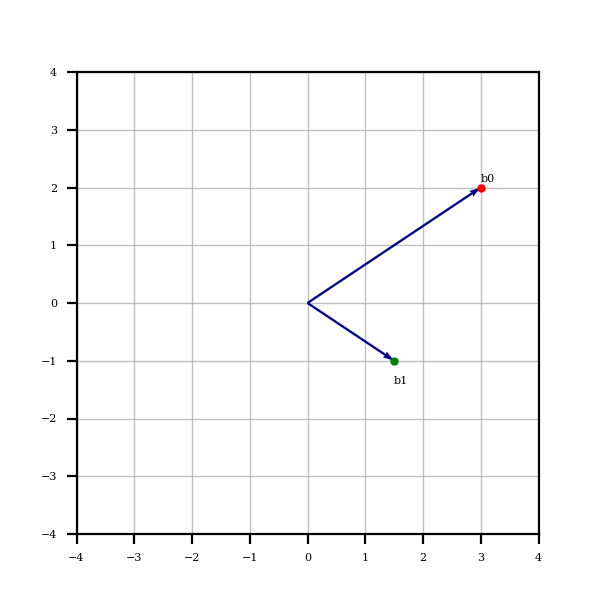

Text(1.5, -1.4, 'b1')

In [49]:
b = np.array([
    [3, 1.5],            # x-coordinates
    [2, -1]              # y-coordinates
])
mk_vplot(4,1)
plot_vector(b.T, colors='darkblue')
plt.plot(b[0,0], b[1,0], 'ro', markersize=2)
plt.plot(b[0,1], b[1,1], 'go', markersize=2)
plt.text(3, 2.1, 'b0')
plt.text(1.5, -1.4, 'b1')

The vector from $b_0$ to $b_1$, denoted $\vec{b_0 b_1}$, is the vector, $x$, such that $b_0 + x = b_1$, i.e. $x = b_1 - b_0$. 

<IPython.core.display.Javascript object>


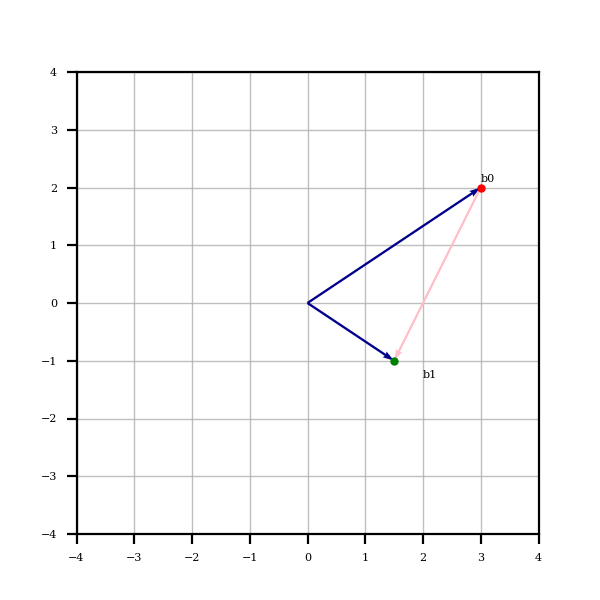

Text(2, -1.3, 'b1')

In [50]:
x = b[:,1] - b[:,0]                                                        
vectors = np.append(b.T, [x], axis=0)                                     
tails = np.zeros_like(vectors)                                              # initially all vector tails are at the origin
tails[2] = vectors[0]                                                       # set the tail of the x vector to b_0
mk_vplot(4,1)                                                               # create grid for plotting
plot_vector(vectors, tails, colors=['darkblue', 'darkblue', 'pink'])        # plot the vectors
plt.plot(b[0,0], b[1,0], 'ro', markersize=2)                                # plot b_0 as a red circle
plt.plot(b[0,1], b[1,1], 'go', markersize=2)                                # plot b_1 as a green circle
plt.text(3, 2.1, 'b0')                                                      # write some helpful text labels
plt.text(2, -1.3, 'b1')

Similarly, the vector from $b_1$ to $b_0$, denoted $\vec{b_1 b_0}$, is given by $b_0 - b_1$.

<IPython.core.display.Javascript object>


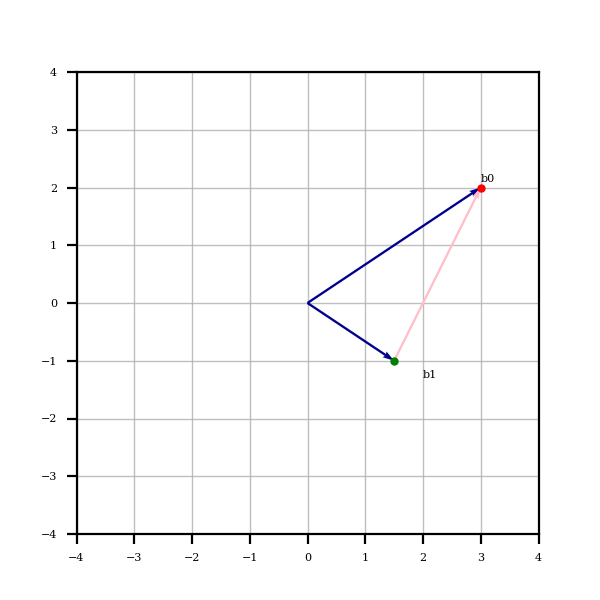

Text(2, -1.3, 'b1')

In [51]:
x = b[:,0] - b[:,1]
vectors = np.append(b.T, [x], axis=0)
tails = np.zeros_like(vectors)
tails[2] = vectors[1]
mk_vplot(4,1)
plot_vector(vectors, tails, colors=['darkblue', 'darkblue', 'pink'])
plt.plot(b[0,0], b[1,0], 'ro', markersize=2)
plt.plot(b[0,1], b[1,1], 'go', markersize=2)
plt.text(3, 2.1, 'b0')
plt.text(2, -1.3, 'b1')

The *magnitude* of the vector, $\vec{b_0 b_1}$, can be obtained by considering the line from $b_0$ to $b_1$ as the hypotenuse of a right-angled triangle whose other sides are parallel to the axes of the coordinate system. The `numpy` function `hypot`  returns the length of the hypotenuse, given the lengths of the other 2 sides, e.g. let $b_0 = (4, 2)$ and $b_1 = (1, -2)$, then the vector $\vec{b_0 b_1}$ has the magnitude shown below.

<IPython.core.display.Javascript object>


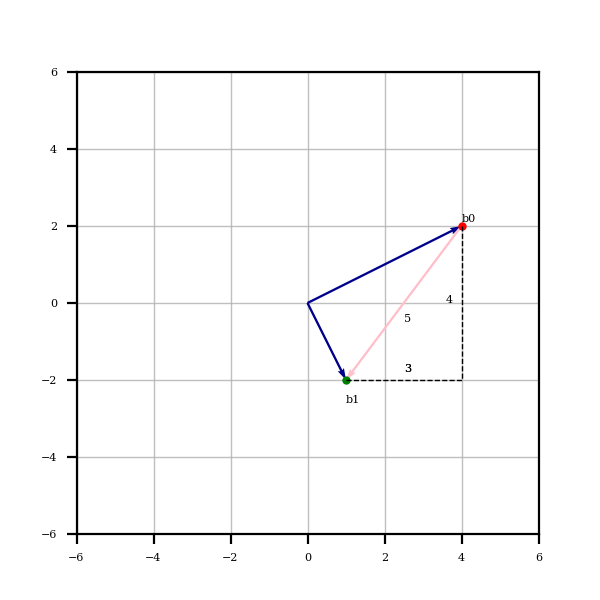

The magnitude of the vector from b0 to b1 is 5.0


In [52]:
b = np.array([
    [4, 1],            # x-coordinates
    [2, -2]            # y-coordinates
])
x = b[:,1] - b[:,0]
vectors = np.append(b.T, [x], axis=0)
tails = np.zeros_like(vectors)
tails[2] = vectors[0]
mk_vplot(6,2)
plot_vector(vectors, tails, colors=['darkblue', 'darkblue', 'pink'])
plt.plot(b[0,0], b[1,0], 'ro', markersize=2)
plt.plot(b[0,1], b[1,1], 'go', markersize=2)
plt.text(4, 2.1, 'b0')
plt.text(1, -2.6, 'b1')
plt.plot([1,4,4], [-2,-2,2], 'k--', linewidth=0.5)
plt.text(2.5, -1.8, '3')
plt.text(2.5, -1.8, '3')
plt.text(3.6, 0., '4')
plt.text(2.5, -0.5, '5')
magx = np.hypot(b[0,0] - b[0,1], b[1,0] - b[1,1])
print(f"The magnitude of the vector from b0 to b1 is {magx}")

We denote the magnitude of $\vec{b_0 b_1}$ by $\big\lVert \vec{b_0 b_1} \big\rVert$.

## Cohesion and Repulsion Fields

Agents in a swarm have two main goals: 

    1. to stay close to other agents, and 
    2. to avoid bumping into other agents.
    
The first goal involves defining a 'cohesion' field, $C_b$, for each agent $b$. The cohesion field of $b$ is specified as a circle of given radius, centred at $b$. Any agent $b'$ that is positioned within the cohesion field of $b$ inclines $b$ to move towards $b'$. The second goal involves defining a 'repulsion' field, $R_b$, in a similar manner to the definition of the cohesion field. Any agent $b'$ that is positioned within the repulsion field of $b$ inclines $b$ to move away from $b'$. Notice that an agent $b'$ that is positioned both within  $b$'s cohesion field *and* its repulsion field will cause $b$ to have conflicting inclinations: both to move towards and to move away from $b'$. The final movement of $b$ depends on the 'strength' of these inclinations.

Two new rows are added to the swarm representation. One row gives the cohesion field for each agent. The other defines the repulsion field. 

Note: A swarm can be represented in the simulator in a variety of ways. The goal here is to find a representation that leads to an efficient implementation of the simulator using Numpy. Here we choose a representation based on a 2-D array in which each row models a single attribute for all agents and each column models all attributes for a single agent, e.g.

| | b0 | b1 | ... | bn |
|---|---|---|---|---|
|x  |   |   |   |   |
|y  |   |   |   |   |
|C  |   |   |   |   |
|R  |   |   |   |   |
|. |   |   |   |   |
|.  |   |   |   |   |
|.  |   |   |   |   |

This is not the most convenient representation when plotting a few agents from a small swarm but it is hoped that it allows efficient implementation of the major operations in the simulator, by taking advantage of Numpy's vectorised operators.

We define a 'helper' function, `plot_field()`, to assist in the illustration of cohesion and repulsion fields.

In [53]:
def plot_field(radius=1.0, fmt='b-', *, linewidth=0.5, pos=(0.0, 0.0)):
    '''
    Draw a circle of specified radius on the current axis
    
    :param radius: the radius of the circle
    :param fmt: the colour and style of line for drawing the circle
    :param linewidth: the width of the line for drawing the circle
    :param pos: the location of the centre of the circle
    '''
    theta = np.linspace(0, 2*np.pi, 100)
    x1 = radius*np.cos(theta) + pos[0]
    x2 = radius*np.sin(theta) + pos[1]
    ax = plt.gca()
    ax.plot(x1, x2, fmt, linewidth=linewidth)
    ax.set_aspect(1)


Now consider an agent, $b_0$, at the origin, with a repulsion field of radius 5 and a cohesion field of radius 7. This can be illustrated as follows:

<IPython.core.display.Javascript object>


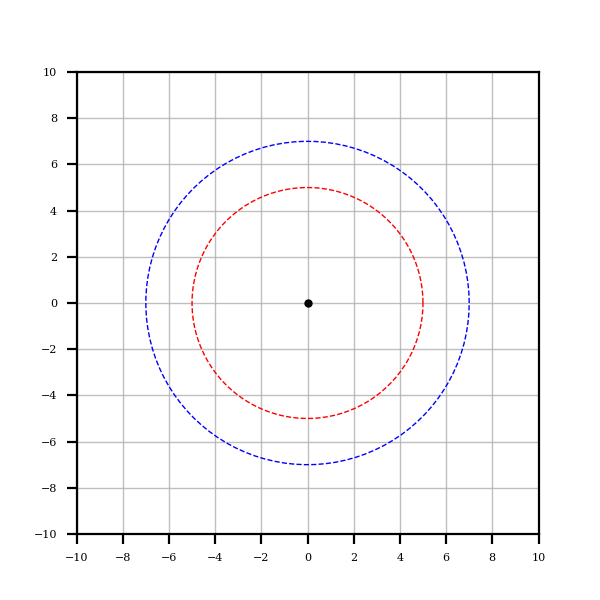

In [54]:
b = np.array([
    [0], # x coordinate
    [0], # y coordinate
    [7], # cohesion field radius
    [5], # repulsion field radius
])
mk_vplot()
plot_field(b[2], 'b--')                      # draw the cohesion field of b[0]
plot_field(b[3], 'r--')                      # draw the repulsion field of b[0]
plt.plot(b[0], b[1], 'ko', markersize=2)     # draw the point for b[0]

## Cohesion vectors

Let's introduce a 2nd agent, $b_1$, into the previous scenario. We'll place $b_1$ at $(3, 3)$, which is within the cohesion field of $b_0$, and observe its effect on $b_0$. 

At this point, notice that it is important to be able to determine, for any agent, which agents are within its cohesion and repulsion fields. The necessary computation is introduced here. We begin by computing the pairwise distances between agents and determining, for each agent pair, whether one agent is within the cohesion / repulsion fields of the other. 

Notice that some constants are introduced to identify the rows of agent attributes in the swarm array. This aids the readability and maintainability of the code, without adversely affecting its performance too much (...it may be worth looking at structured arrays as an alternative to this approach). Some rows are introduced into the array to hold the results of computations of cohesion and repulsion vectors. It is expected that this approach will simplify the saving of swarm states when that functionality is introduced later.

<IPython.core.display.Javascript object>


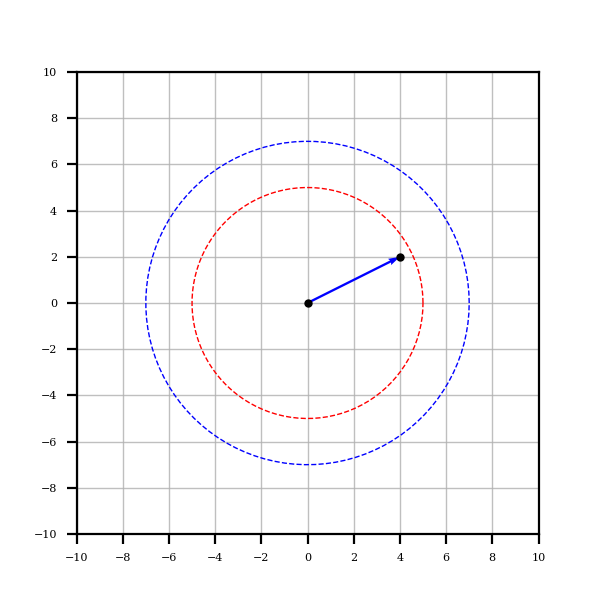

In [55]:
# Define some useful array row constants for agent attributes
POS_X  = 0    # x-coordinates of agents' position 
POS_Y  = 1    # y-coordinates of agents' position
COH_X  = 2    # x-coordinates of cohesion vectors
COH_Y  = 3    # y-coordinates of cohesion vectors
REP_X  = 4    # x-coordinates of repulsion vectors
REP_Y  = 5    # y-coordinates of repulsion vectors
CF     = 6    # cohesion field radii
RF     = 7    # repulsion field radii

b = np.array([
    [0.0, 4.0], # x-coordinates of agents' position
    [0.0, 2.0], # y-coordinates of agents' position
    [0.0, 0.0], # x-coordinates of cohesion vector
    [0.0, 0.0], # y-coordinates of cohesion vector
    [0.0, 0.0], # x-coordinates of repulsion vector
    [0.0, 0.0], # y-coordinates of repulsion vector
    [7.0, 7.0], # cohesion field radii
    [5.0, 5.0], # repulsion field radii
])
xv = np.subtract.outer(b[POS_X], b[POS_X])  # compute all pairs x-differences
yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # compute all pairs y-differences

# compute all pairwise vector magnitudes
mag = np.hypot(xv, yv)              # all pairs magnitudes

# compute the cohesion neighbours
coh_n = mag <= b[CF]               # test for those pairs of agents for which one is within the cohesion field of the other  
np.fill_diagonal(coh_n, False)     # no agent is a cohesion neighbour of itself
nr_coh_n = np.sum(coh_n, axis = 0) # number of cohesion neighbours of each agent

# compute the x-differences and y-differences for cohesion vectors
xv_coh = np.where(coh_n, xv, 0.0)   # where coh_n is True take the corresponding value from xv, otherwise 0.0
yv_coh = np.where(coh_n, yv, 0.0)   # where coh_n is True take the corresponding value from yv, otherwise 0.0

# compute the cohesion vectors 
b[COH_X] = xv_coh.sum(axis=0)                       # sum the x-differences 
b[COH_Y] = yv_coh.sum(axis=0)                       # sum the y-differences
b[COH_X:COH_Y+1] /= np.maximum(nr_coh_n, 1)         # divide by the number of cohesion neighbours

# do plotting of results
mk_vplot()
plot_field(b[CF, 0], 'b--')                             # draw the cohesion field of b[0]
plot_field(b[RF, 0], 'r--')                             # draw the repulsion field of b[0]
plt.plot(b[POS_X], b[POS_Y], 'ko', markersize=2)        # draw the agent points 
coh_v_0 = np.column_stack((xv_coh.T[0], yv_coh.T[0]))   # get cohesion vector for agent 0 - just for plotting            
plot_vector(coh_v_0, colors='blue')                    # draw the cohesion vector from b[0] to b[1]

It's worth having a look at some of the intermediate data structures in the previous example.

The `xv` (resp. `yv`) array holds all pairwise x-differences (resp. y-differences). The cell `xv[i,j]` is set to `b[POS_X, i] - b[POS_X, j]`, i.e. it gives the difference in x-value between the positions of agent `i` and agent `j`; Similarly, `yv[i,j]` is set to `b[POS_Y, i] - b[POS_Y, j]`, i.e. it gives the difference in y-value between the positions of agent `i` and agent `j`. Note that the x- and y-values for the vector $\vec{b_i b_j}$ are to be found at `xv[j,i]` and `yv[j,i]`, respectively. The `mag` array holds all pairwise magnitudes. The distance between agent `i` and agent `j`, or equivalently, the magnitude of the vector 
$\vec{b_i b_j}$, is to be found at `mag[j,i]`. Of course, in any sane world, $\lVert\vec{b_i b_j}\rVert = \lVert\vec{b_j b_i}\rVert$ but you can't be too careful!

In [56]:
print(f"xv is \n {xv}")
print(f"yv is \n {yv}")
print(f"mag is \n {mag}")

xv is 
 [[ 0. -4.]
 [ 4.  0.]]
yv is 
 [[ 0. -2.]
 [ 2.  0.]]
mag is 
 [[0.         4.47213595]
 [4.47213595 0.        ]]


The array `coh_n` is a boolean array where `coh_n[i, j]` is `True` if the position of agent i lies within the cohesion field of agent j, i.e. agent i is a cohesion *neighbour* of agent j. So `coh_n[:, j]` gives all the cohesion neighbours of agent `j`. The array `nr_coh_n` gives the number of cohesion neighbours of each agent. Note `np.sum()` counts every `True` as 1 and every `False` as 0. We are summing along `axis=0`, i.e. down the rows, so, for example, `nr_coh_n[j]` gives the number of cohesion neighbours of agent `j`.

In [57]:
print(f"coh_n is \n {coh_n}")
print(f"nr_coh_n is \n {nr_coh_n}")

coh_n is 
 [[False  True]
 [ True False]]
nr_coh_n is 
 [1 1]


The array `xv_coh` (resp. `yv_coh`) is the same as `xv` (resp. `yv`) in those cells, `xv[i, j]` (resp. `yv[i, j]`), where `coh_n[i, j]` is `True` and is 0.0 in the remaining cells. The final x- and y-values of the cohesion vectors are computed by summing down the rows (axis=0) in `xv_coh` and `yv_coh` and dividing by the number of cohesion neighbours. See below.

In [58]:
print(f"xv_coh is \n {xv_coh}")
print(f"yv_coh is \n {yv_coh}")
print(f"b[COH_X:COH_Y+1] is \n {b[COH_X:COH_Y+1]}")

xv_coh is 
 [[ 0. -4.]
 [ 4.  0.]]
yv_coh is 
 [[ 0. -2.]
 [ 2.  0.]]
b[COH_X:COH_Y+1] is 
 [[ 4. -4.]
 [ 2. -2.]]


##  Repulsion vectors

The presence of $b_1$ within the cohesion field of $b_0$ gives $b_0$ an inclination to move towards $b_1$. 
The 'strength' of the inclination is given by $\lVert\vec{b_0 b_1}\rVert$. Notice also that $b_1$ lies within the repulsion field of $b_0$. This gives $b_0$ an inclination to move away from $b_1$. This is calculated as 
$(\frac{\lVert\vec{b_0 b_1}\rVert}{R_{b_0}} - 1)\vec{b_0 b_1}$. The factor $(\frac{\lVert\vec{b_0 b_1}\rVert}{R_{b_0}} - 1)$ is used to reverse the direction, and to dampen the effect, of $\vec{b_0 b_1}$, giving $b_0$ a 'gentle' inclination to move away from $b_1$. This can be illustrated by adding a new vector to the previous figure, as follows:

<IPython.core.display.Javascript object>


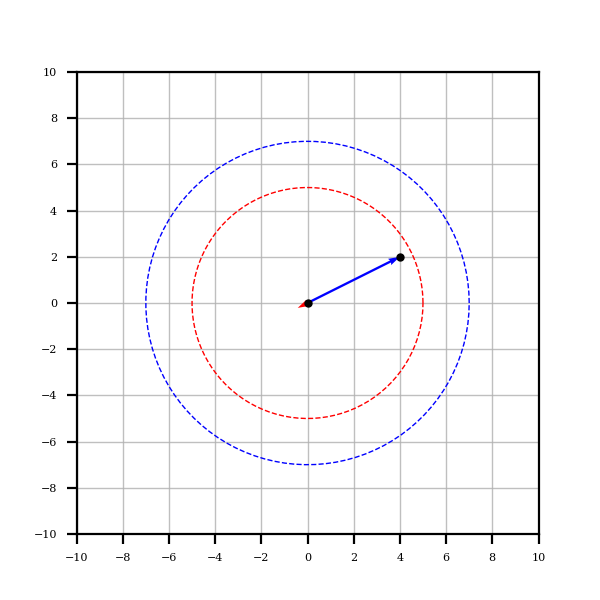

In [59]:
# compute the repulsion neighbours
rep_n = mag <= b[RF]               # test for those pairs of agents for which one is within the repulsion field of the other
np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
nr_rep_n = np.sum(rep_n, axis = 0) # number of repulsion neighbours of each agent

# compute the x-differences and y-differences  for repulsion vectors
rscalar = mag / b[RF] - 1
xv_rep = np.where(rep_n, xv * rscalar, 0.0)
yv_rep = np.where(rep_n, yv * rscalar, 0.0)

# compute the resultant repulsion vectors 
b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences
b[REP_X:REP_Y+1] /= np.maximum(nr_rep_n, 1)         # divide by the number of repulsion neighbours

# plot the results
mk_vplot()
plot_field(b[CF, 0], 'b--')                                           # draw the cohesion field of b[0]
plot_field(b[RF, 0], 'r--')                                           # draw the repulsion field of b[0]
plt.plot(b[POS_X], b[POS_Y], 'ko', markersize=2)                      # draw the agent points 
coh_v_0 = np.column_stack((xv_coh.T[0], yv_coh.T[0]))                 # get cohesion vectors for agent 0 - just for plotting            
plot_vector(coh_v_0, colors='blue')                                  # draw the cohesion vector from b[0] to b[1]
rep_v_0 = np.column_stack((xv_rep.T[0], yv_rep.T[0]))                 # get repulsion vectors for agent 0 - just for plotting            
plot_vector(rep_v_0, colors='red')                                    # draw the repulsion vector from b[0] to b[1]


At this stage, the repulsion effect is negligible (you can just about see a tiny red arrow pointing away from the origin). However, observe what happens when $b_1$ approaches closer to $b_0$.

<IPython.core.display.Javascript object>


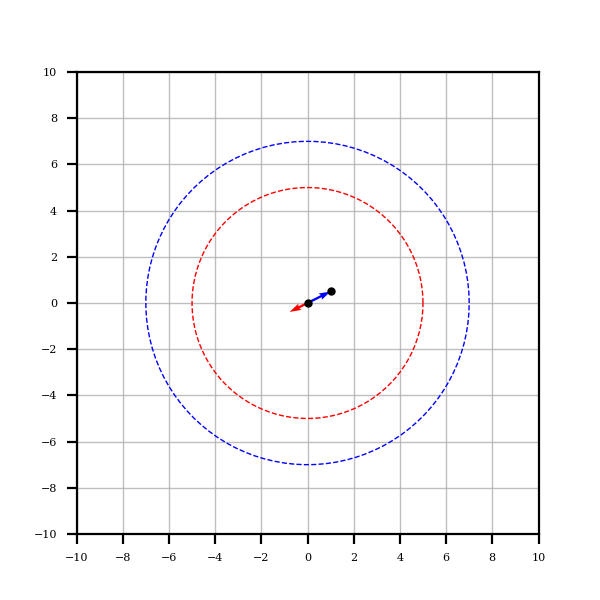

In [60]:
# Define some useful array row constants for agent attributes
POS_X  = 0    # x-coordinates of agents' position 
POS_Y  = 1    # y-coordinates of agents' position
COH_X  = 2    # x-coordinates of cohesion vectors
COH_Y  = 3    # y-coordinates of cohesion vectors
REP_X  = 4    # x-coordinates of repulsion vectors
REP_Y  = 5    # y-coordinates of repulsion vectors
CF     = 6    # cohesion field radii
RF     = 7    # repulsion field radii

b = np.array([
    [0.0, 1.0], # x-coordinates of agents' position
    [0.0, 0.5], # y-coordinates of agents' position
    [0.0, 0.0], # x-coordinates of cohesion vector
    [0.0, 0.0], # y-coordinates of cohesion vector
    [0.0, 0.0], # x-coordinates of repulsion vector
    [0.0, 0.0], # y-coordinates of repulsion vector
    [7.0, 7.0], # cohesion field radii
    [5.0, 5.0], # repulsion field radii
])
xv = np.subtract.outer(b[POS_X], b[POS_X])  # compute all pairs x-differences
yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # compute all pairs y-differences

# compute all pairwise vector magnitudes
mag = np.hypot(xv, yv)              # all pairs magnitudes

# compute the cohesion neighbours
coh_n = mag <= b[CF]               # test for those pairs of agents for which one is within the cohesion field of the other  
np.fill_diagonal(coh_n, False)     # no agent is a cohesion neighbour of itself
nr_coh_n = np.sum(coh_n, axis = 0) # number of cohesion neighbours of each agent

# compute the x-differences and y-differences for cohesion vectors
xv_coh = np.where(coh_n, xv, 0.0)
yv_coh = np.where(coh_n, yv, 0.0)

# compute the cohesion vectors 
b[COH_X] = xv_coh.sum(axis=0)                       # sum the x-differences 
b[COH_Y] = yv_coh.sum(axis=0)                       # sum the y-differences
b[COH_X:COH_Y+1] /= np.maximum(nr_coh_n, 1)         # divide by the number of cohesion neighbours

# compute the repulsion neighbours
rep_n = mag <= b[RF]
np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
nr_rep_n = np.sum(rep_n, axis = 0) # number of repulsion neighbours of each agent

# compute the x-differences  and y-differences for repulsion vectors
rscalar = mag / b[RF] - 1
xv_rep = np.where(rep_n, xv * rscalar, 0.0)
yv_rep = np.where(rep_n, yv * rscalar, 0.0)

# compute the resultant repulsion vectors 
b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences
b[REP_X:REP_Y+1] /= np.maximum(nr_rep_n, 1)         # divide by the number of repulsion neighbours

# plot the results
mk_vplot()
plot_field(b[CF, 0], 'b--')                                         # draw the cohesion field of b[0]
plot_field(b[RF, 0], 'r--')                                         # draw the repulsion field of b[0]
plt.plot(b[POS_X], b[POS_Y], 'ko', markersize=2)                    # draw the agent points 
coh_v_0 = np.column_stack((xv_coh.T[0], yv_coh.T[0]))               # get cohesion vectors for agent 0 - just for plotting              
plot_vector(coh_v_0, colors='blue')                                # draw the cohesion vector from b[0] to b[1]
rep_v_0 = np.column_stack((xv_rep.T[0], yv_rep.T[0]))               # get repulsion vectors for agent 0 - just for plotting            
plot_vector(rep_v_0, colors='red')                                  # draw the repulsion vector from b[0] to b[1]

Now the repulsion effect is a little stronger.
Puzzlingly, however, as $b_1$ continues to approach $b_0$, drawing closer to it, even to the point of collision, the repulsion effect eventually begins to grow *weaker*. We'll return to this anomaly later.

Now consider what happens if a third agent is added to this scenario, at position $(-2, 3)$ with cohesion field $7$ and repulsion field $5$.

<IPython.core.display.Javascript object>


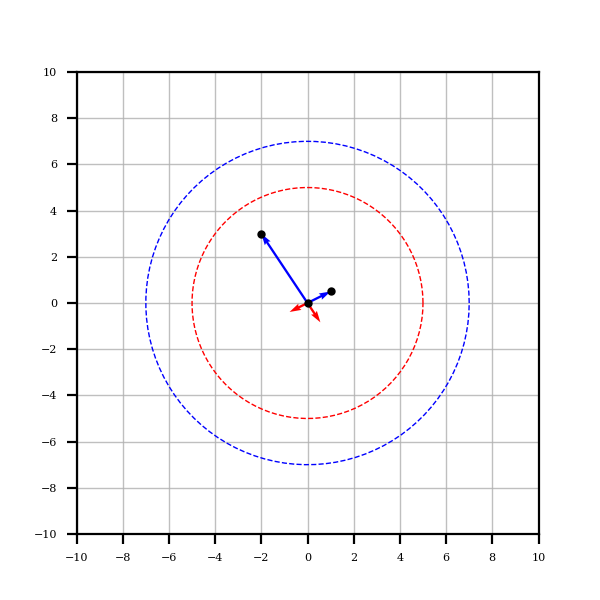

In [61]:
# Define some useful array row constants for agent attributes
POS_X  = 0    # x-coordinates of agents' position 
POS_Y  = 1    # y-coordinates of agents' position
COH_X  = 2    # x-coordinates of cohesion vectors
COH_Y  = 3    # y-coordinates of cohesion vectors
REP_X  = 4    # x-coordinates of repulsion vectors
REP_Y  = 5    # y-coordinates of repulsion vectors
CF     = 6    # cohesion field radii
RF     = 7    # repulsion field radii

b = np.array([
    [0.0, 1.0, -2.0], # x-coordinates of agents' position
    [0.0, 0.5, 3.0],  # y-coordinates of agents' position
    [0.0, 0.0, 0.0],  # x-coordinates of cohesion vector
    [0.0, 0.0, 0.0],  # y-coordinates of cohesion vector
    [0.0, 0.0, 0.0],  # x-coordinates of repulsion vector
    [0.0, 0.0, 0.0],  # y-coordinates of repulsion vector
    [7.0, 7.0, 7.0],  # cohesion field radii
    [5.0, 5.0, 5.0],  # repulsion field radii
])
xv = np.subtract.outer(b[POS_X], b[POS_X])  # compute all pairs x-differences
yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # compute all pairs y-differences

# compute all pairwise vector magnitudes
mag = np.hypot(xv, yv)              # all pairs magnitudes

# compute the cohesion neighbours
coh_n = mag <= b[CF]               # test for those pairs of agents for which one is within the cohesion field of the other  
np.fill_diagonal(coh_n, False)     # no agent is a cohesion neighbour of itself
nr_coh_n = np.sum(coh_n, axis = 0) # number of cohesion neighbours of each agent

# compute the x-differences and y-differences for cohesion vectors
xv_coh = np.where(coh_n, xv, 0.0)
yv_coh = np.where(coh_n, yv, 0.0)

# compute the resultant cohesion vectors 
b[COH_X] = xv_coh.sum(axis=0)                       # sum the x-differences 
b[COH_Y] = yv_coh.sum(axis=0)                       # sum the y-differences
b[COH_X:COH_Y+1] /= np.maximum(nr_coh_n, 1)         # divide by the number of cohesion neighbours

# compute the repulsion neighbours
rep_n = mag <= b[RF]               # test for those pairs of agents for which one is within the repulsion field of the other
np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
nr_rep_n = np.sum(rep_n, axis = 0) # number of repulsion neighbours of each agent

# compute the x-differences and y-differences for repulsion vectors
rscalar = mag / b[RF] - 1
xv_rep = np.where(rep_n, xv * rscalar, 0.0)
yv_rep = np.where(rep_n, yv * rscalar, 0.0)

# compute the resultant repulsion vectors 
b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences
b[REP_X:REP_Y+1] /= np.maximum(nr_rep_n, 1)         # divide by the number of repulsion neighbours

# plot the results
mk_vplot()
plot_field(b[CF, 0], 'b--')                             # draw the cohesion field of b[0]
plot_field(b[RF, 0], 'r--')                             # draw the repulsion field of b[0]
plt.plot(b[POS_X], b[POS_Y], 'ko', markersize=2)        # draw the agent points 
coh_v_0 = np.column_stack((xv_coh.T[0], yv_coh.T[0]))   # get cohesion vectors for agent 0 - just for plotting            
plot_vector(coh_v_0, colors='blue')                    # draw the cohesion vectors from b[0] to b[1] and b[2]
rep_v_0 = np.column_stack((xv_rep.T[0], yv_rep.T[0]))   # get repulsion vectors for agent 0 - just for plotting 
plot_vector(rep_v_0, colors='red')                      # draw the repulsion vectors from b[0] to b[1] and b[2]

Now $b_0$ experiences cohesion and repulsion effects from *both* agents within its cohesion and repulsion fields (again, we note that it is puzzling that the 'strength' of repulsion caused by the closer agent is less that that caused by the agent that is further away). The net cohesion (resp. repulsion) effect on $b_0$ is given by the mean of the sum of the cohesion (resp. repulsion) effects arising from $b_1$ and $b_2$, as follows:

<IPython.core.display.Javascript object>


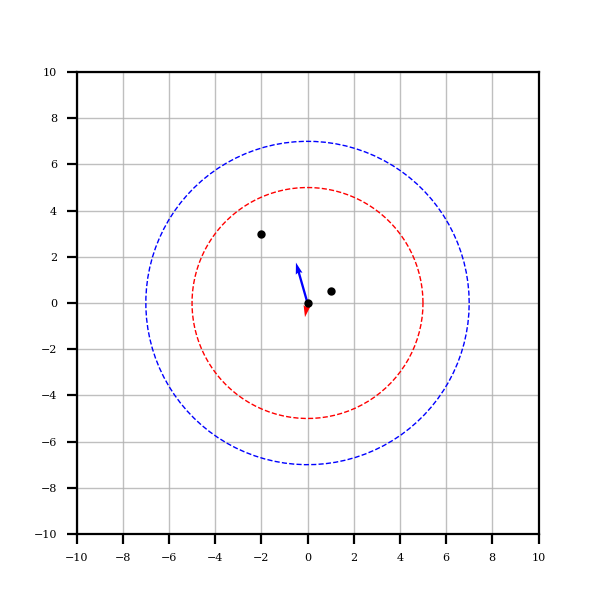

In [62]:
# Define some useful array row constants for agent attributes
POS_X  = 0    # x-coordinates of agents' position 
POS_Y  = 1    # y-coordinates of agents' position
COH_X  = 2    # x-coordinates of cohesion vectors
COH_Y  = 3    # y-coordinates of cohesion vectors
REP_X  = 4    # x-coordinates of repulsion vectors
REP_Y  = 5    # y-coordinates of repulsion vectors
CF     = 6    # cohesion field radii
RF     = 7    # repulsion field radii

b = np.array([
    [0.0, 1.0, -2.0], # x-coordinates of agents' position
    [0.0, 0.5, 3.0],  # y-coordinates of agents' position
    [0.0, 0.0, 0.0],  # x-coordinates of cohesion vector
    [0.0, 0.0, 0.0],  # y-coordinates of cohesion vector
    [0.0, 0.0, 0.0],  # x-coordinates of repulsion vector
    [0.0, 0.0, 0.0],  # y-coordinates of repulsion vector
    [7.0, 7.0, 7.0],  # cohesion field radii
    [5.0, 5.0, 5.0],  # repulsion field radii
])
xv = np.subtract.outer(b[POS_X], b[POS_X])  # compute all pairs x-differences
yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # compute all pairs y-differences

# compute all pairwise vector magnitudes
mag = np.hypot(xv, yv)              # all pairs magnitudes

# compute the cohesion neighbours
coh_n = mag <= b[CF]               # test for those pairs of agents for which one is within the cohesion field of the other  
np.fill_diagonal(coh_n, False)     # no agent is a cohesion neighbour of itself
nr_coh_n = np.sum(coh_n, axis = 0) # number of cohesion neighbours of each agent

# compute the x-differences and y-differences for cohesion vectors
xv_coh = np.where(coh_n, xv, 0.0)
yv_coh = np.where(coh_n, yv, 0.0)

# compute the resultant cohesion vectors 
b[COH_X] = xv_coh.sum(axis=0)                       # sum the x-differences 
b[COH_Y] = yv_coh.sum(axis=0)                       # sum the y-differences
b[COH_X:COH_Y+1] /= np.maximum(nr_coh_n, 1)         # divide by the number of cohesion neighbours

# compute the repulsion neighbours
rep_n = mag <= b[RF]
np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
nr_rep_n = np.sum(rep_n, axis = 0) # number of repulsion neighbours of each agent

# compute the x-differences and y-differences for repulsion vectors
rscalar = mag / b[RF] - 1
xv_rep = np.where(rep_n, xv * rscalar, 0.0)
yv_rep = np.where(rep_n, yv * rscalar, 0.0)

# compute the resultant repulsion vectors 
b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences
b[REP_X:REP_Y+1] /= np.maximum(nr_rep_n, 1)         # divide by the number of repulsion neighbours

# plot the results
mk_vplot()
plot_field(b[CF, 0], 'b--')                             # draw the cohesion field of b[0]
plot_field(b[RF, 0], 'r--')                             # draw the repulsion field of b[0]
plt.plot(b[POS_X], b[POS_Y], 'ko', markersize=2)        # draw the agent points 
plot_vector(b[COH_X:COH_Y+1].T[0,np.newaxis], colors='blue')    # draw the resultant cohesion vector for b[0]
plot_vector(b[REP_X:REP_Y+1].T[0,np.newaxis], colors='red')      # draw the resultant repulsion vectors for b[0]

Of course, agents $b_1$ and $b_2$ also experience similar effects due to the agents in their vicinity. This is shown below.

<IPython.core.display.Javascript object>


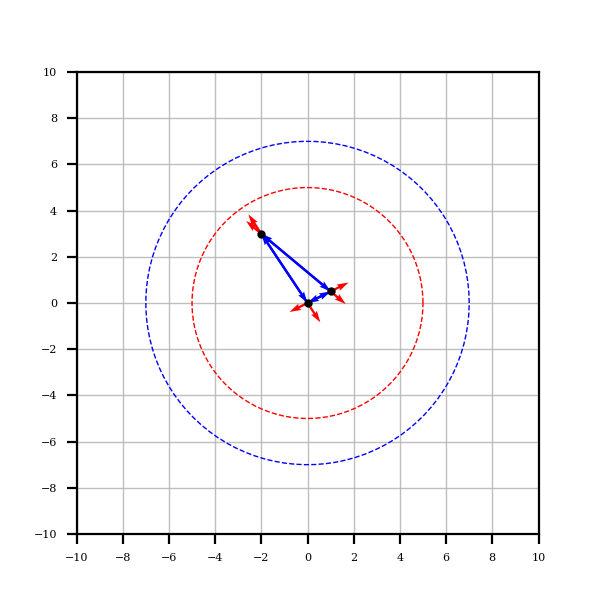

In [63]:
# Define some useful array row constants for agent attributes
POS_X  = 0    # x-coordinates of agents' position 
POS_Y  = 1    # y-coordinates of agents' position
COH_X  = 2    # x-coordinates of cohesion vectors
COH_Y  = 3    # y-coordinates of cohesion vectors
REP_X  = 4    # x-coordinates of repulsion vectors
REP_Y  = 5    # y-coordinates of repulsion vectors
CF     = 6    # cohesion field radii
RF     = 7    # repulsion field radii

b = np.array([
    [0.0, 1.0, -2.0], # x-coordinates of agents' position
    [0.0, 0.5, 3.0],  # y-coordinates of agents' position
    [0.0, 0.0, 0.0],  # x-coordinates of cohesion vector
    [0.0, 0.0, 0.0],  # y-coordinates of cohesion vector
    [0.0, 0.0, 0.0],  # x-coordinates of repulsion vector
    [0.0, 0.0, 0.0],  # y-coordinates of repulsion vector
    [7.0, 7.0, 7.0],  # cohesion field radii
    [5.0, 5.0, 5.0],  # repulsion field radii
])
xv = np.subtract.outer(b[POS_X], b[POS_X])  # compute all pairs x-differences
yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # compute all pairs y-differences

# compute all pairwise vector magnitudes
mag = np.hypot(xv, yv)              # all pairs magnitudes

# compute the cohesion neighbours
coh_n = mag <= b[CF]               # test for those pairs of agents for which one is within the cohesion field of the other  
np.fill_diagonal(coh_n, False)     # no agent is a cohesion neighbour of itself
nr_coh_n = np.sum(coh_n, axis = 0) # number of cohesion neighbours ofeach agent

# compute the x-differences and y-differences for cohesion vectors
xv_coh = np.where(coh_n, xv, 0.0)
yv_coh = np.where(coh_n, yv, 0.0)

# compute the resultant cohesion vectors 
b[COH_X] = xv_coh.sum(axis=0)                       # sum the x-differences 
b[COH_Y] = yv_coh.sum(axis=0)                       # sum the y-differences
b[COH_X:COH_Y+1] /= np.maximum(nr_coh_n, 1)         # divide by the number of cohesion neighbours

# compute the repulsion neighbours
rep_n = mag <= b[RF]
np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
nr_rep_n = np.sum(rep_n, axis = 0) # number of repulsion neighbours of each agent

# compute the x-differences and y-differences for repulsion vectors
rscalar = mag / b[RF] - 1
xv_rep = np.where(rep_n, xv * rscalar, 0.0)
yv_rep = np.where(rep_n, yv * rscalar, 0.0)

# compute the resultant repulsion vectors 
b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences
b[REP_X:REP_Y+1] /= np.maximum(nr_rep_n, 1)         # divide by the number of repulsion neighbours

# plot the results
mk_vplot()
plot_field(b[CF, 0], 'b--')                             # draw the cohesion field of b[0]
plot_field(b[RF, 0], 'r--')                             # draw the repulsion field of b[0]
plt.plot(b[POS_X], b[POS_Y], 'ko', markersize=2)        # draw the agent points 
tails = b[POS_X:POS_Y+1].T                              # each agent acts as the 'tail' for its cohesion and repulsion vectors
coh_vectors = np.stack((xv_coh.T, yv_coh.T), axis=2)    # compute the targets of the cohesion vectors for each agent
for i in range(len(coh_vectors)):                       # plot the cohesion vectors for all agents
    plot_vector(coh_vectors[i], tails[i,np.newaxis], colors='blue')   # draw the cohesion vectors
rep_vectors = np.stack((xv_rep.T, yv_rep.T), axis=2)    # compute the targets of the repulsion vectors for each agent
for i in range(len(rep_vectors)):                       # plot the repulsion vectors for all agents
    plot_vector(rep_vectors[i], tails[i, np.newaxis], colors='red')   # draw the repulsion vectors

## Resultant of cohesion and repulsion vectors

The movement of each agent is influenced by the sum of its cohesion and repulsion vectors. This sum is known as the *resultant* of the cohesion and repulsion vectors. Here we add 2 additional rows (RES_X and RES_Y) to the swarm state array to store the x- and y-coordinates of the overall resultant vectors.

<IPython.core.display.Javascript object>


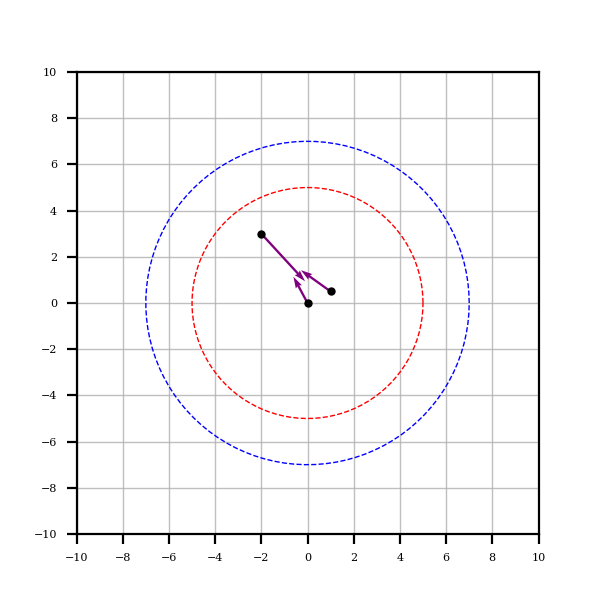

In [64]:
# Define some useful array row constants for agent attributes
POS_X  = 0    # x-coordinates of agents' position 
POS_Y  = 1    # y-coordinates of agents' position
COH_X  = 2    # x-coordinates of cohesion vectors
COH_Y  = 3    # y-coordinates of cohesion vectors
REP_X  = 4    # x-coordinates of repulsion vectors
REP_Y  = 5    # y-coordinates of repulsion vectors
RES_X  = 6    # x-coordinates of resultant vectors
RES_Y  = 7    # y-coordinates of resultant vectors
CF     = 8    # cohesion field radii
RF     = 9    # repulsion field radii

b = np.array([
    [0.0, 1.0, -2.0], # x-coordinates of agents' position
    [0.0, 0.5, 3.0],  # y-coordinates of agents' position
    [0.0, 0.0, 0.0],  # x-coordinates of cohesion vector
    [0.0, 0.0, 0.0],  # y-coordinates of cohesion vector
    [0.0, 0.0, 0.0],  # x-coordinates of repulsion vector
    [0.0, 0.0, 0.0],  # y-coordinates of repulsion vector
    [0.0, 0.0, 0.0],  # x-coordinates of resultant vector
    [0.0, 0.0, 0.0],  # y-coordinates of resultant vector
    [7.0, 7.0, 7.0],  # cohesion field radii
    [5.0, 5.0, 5.0],  # repulsion field radii
])
xv = np.subtract.outer(b[POS_X], b[POS_X])  # compute all pairs x-differences
yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # compute all pairs y-differences

# compute all pairwise vector magnitudes
mag = np.hypot(xv, yv)              # all pairs magnitudes

# compute the cohesion neighbours
coh_n = mag <= b[CF]               # test for those pairs of agents for which one is within the cohesion field of the other  
np.fill_diagonal(coh_n, False)     # no agent is a cohesion neighbour of itself
nr_coh_n = np.sum(coh_n, axis = 0) # number of cohesion neighbours of each agent

# compute the x-differences and y-differences for cohesion vectors
xv_coh = np.where(coh_n, xv, 0.0)
yv_coh = np.where(coh_n, yv, 0.0)

# compute the resultant cohesion vectors 
b[COH_X] = xv_coh.sum(axis=0)                       # sum the x-differences 
b[COH_Y] = yv_coh.sum(axis=0)                       # sum the y-differences
b[COH_X:COH_Y+1] /= np.maximum(nr_coh_n, 1)         # divide by the number of cohesion neighbours

# compute the repulsion neighbours
rep_n = mag <= b[RF]
np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
nr_rep_n = np.sum(rep_n, axis = 0) # number of repulsion neighbours ofeach agent

# compute the x-differences and y-differences for repulsion vectors
rscalar = mag / b[RF] - 1
xv_rep = np.where(rep_n, xv * rscalar, 0.0)
yv_rep = np.where(rep_n, yv * rscalar, 0.0)

# compute the resultant repulsion vectors 
b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences
b[REP_X:REP_Y+1] /= np.maximum(nr_rep_n, 1)         # divide by the number of repulsion neighbours

# compute the overall resultant of the cohesion and repulsion vectors
b[RES_X:RES_Y+1] = b[COH_X:COH_Y+1] + b[REP_X:REP_Y+1] 

# plot the results
mk_vplot()
plot_field(b[CF, 0], 'b--')                             # draw the cohesion field of b[0]
plot_field(b[RF, 0], 'r--')                             # draw the repulsion field of b[0]
plt.plot(b[POS_X], b[POS_Y], 'ko', markersize=2)        # draw the agent points 
plot_vector(b[RES_X:RES_Y+1].T, b[POS_X:POS_Y+1].T, colors='purple')     # draw the resultant vectors for all agents

## Random swarms, goals, direction vectors and weights

So far, we have considered only swarms in which all agents are within the cohesion and repulsion fields of each other. It is very unlikely that this will be the case in general. We introduce a function `mk_rand_swarm()` to create swarms in which the initial placement of agents inside or outside the cohesion or repulsion fields of other agents occurs randomly. As a convenience, we also introduce a function, `mk_swarm()`, for the easy creation of swarms of agents whose initial positions are specified by the caller.

Two further ideas are introduced:

    1. a goal position for the swarm to settle on, inducing a direction vector for each agent; 
    2. weighting factors to allow different weights to be placed on the cohesion, repulsion and direction components of the overall
       resultant vector for each agent.
       
Notice that a goal, $g$, induces a direction vector, $\vec{b g}$, for each agent $b$. As usual, the vector $\vec{b g}$ is computed as $g - b$. Now, the overall resultant vector for each agent, $b$, is computed as the weighted sum of its cohesion, repulsion and direction vectors.

In [65]:
# Define some useful array accessor constants
POS_X  = 0    # x-coordinates of agents position 
POS_Y  = 1    # y-coordinates of agents position
COH_X  = 2    # x-coordinates of cohesion vectors
COH_Y  = 3    # y-coordinates of cohesion vectors
REP_X  = 4    # x-coordinates of repulsion vectors
REP_Y  = 5    # y-coordinates of repulsion vectors
DIR_X  = 6    # x-coordinates of direction vectors
DIR_Y  = 7    # y-coordinates of direction vectors
RES_X  = 8    # x-coordinates of resultant vectors
RES_Y  = 9    # y-coordinates of resultant vectors
GOAL_X = 10   # x-coordinates of goals
GOAL_Y = 11   # y-coordinates of goals
CF     = 12   # cohesion field radii
RF     = 13   # repulsion field radii
KC     = 14   # cohesion vector scaling factor
KR     = 15   # repulsion vector scaling factor
KD     = 16   # direction vector scaling factor

N_ROWS = 17   # number of rows in array that models swarm state

def mk_rand_swarm(n, *, cf=4.0, rf=3.0, kc=1.0, kr=1.0, kd=0.0, goal=0.0, loc=0.0, grid=10):
    '''
    create a 2-D array of N_ROWS attributes for n agents. 
    
    :param n:      number of agents
    :param cf:     cohesion field radius of all agents; default 4.0; heterogeneous fields are allowed but not catered for here
    :param rf:     repulsion field radius of all agents; default 3.0
    :param kc:     weighting factor for cohesion component, default 1.0
    :param kr:     weighting factor for repulsion component, default 1.0
    :param kd:     weighting factor for direction component, default 0.0 (i.e. goal is ignored by default)
    :param goal:   location of a goal for all agents; heterogeneous goals are allowed but not catered for here
    :param loc:    location of agent b_0 -- the focus of the swarm
    :param grid:   size of grid around b_0 in which all other agents will be placed initially at random
    '''
    b = np.empty((N_ROWS, n))                       #create a 2-D array, big enough for n agents
    b[POS_X:POS_Y + 1,:] = (np.random.uniform(size=2 * n) * 2 * grid - grid + loc).reshape(2, n) # place agents randomly
    b[POS_X:POS_Y + 1,0] = loc                      # b_0 placed at [loc, loc]       
    b[COH_X:COH_Y+1,:] = np.full((2,n), 0.0)        # cohesion vectors initially [0.0, 0.0]
    b[REP_X:REP_Y+1,:] = np.full((2,n), 0.0)        # repulsion vectors initially [0.0, 0.0]
    b[DIR_X:DIR_Y+1,:] = np.full((2,n), 0.0)        # direction vectors initially [0.0, 0.0]
    b[RES_X:RES_Y + 1,:] = np.full((2,n), 0.0)      # resultant vectors initially [0.0, 0.0]
    b[GOAL_X:GOAL_Y + 1,:] = np.full((2,n), goal)   # goal is at [goal, goal], default [0.0, 0.0]
    b[CF,:] = np.full(n, cf)                        # cohesion field of all agents set to cf
    b[RF,:] = np.full(n, rf)                        # repulsion field of all agents set to rf
    b[KC,:] = np.full(n, kc)                        # cohesion weight for all agents set to kc
    b[KR,:] = np.full(n, kr)                        # repulsion weight for all agents set to kr
    b[KD,:] = np.full(n, kd)                        # direction weight for all agents set to kd
    return b

def mk_swarm(xs, ys, *, cf=4.0, rf=3.0, kc=1.0, kr=1.0, kd=0.0, goal=0.0, grid=10):
    '''
    create a 2-D array of N_ROWS attributes for len(xs) agents. 
    
    :param xs:      x-values of position of agents
    :param ys:      y-values of position of agents
    :param cf:      cohesion field radius of all agents; default 4.0; heterogeneous fields are allowed but not catered for here
    :param rf:      repulsion field radius of all agents; default 3.0
    :param kc:      weighting factor for cohesion component, default 1.0
    :param kr:      weighting factor for repulsion component, default 1.0
    :param kd:      weighting factor for direction component, default 0.0 (i.e. goal is ignored by default)
    :param goal:    location of a goal for all agents; heterogeneous goals are allowed but not catered for here
    :param loc:     location of agent b_0 -- the focus of the swarm
    :param grid:    size of grid around b_0 in which all other agents will be placed initially at random
    '''
    n = len(xs)
    assert len(ys) == n
    b = np.empty((N_ROWS, n))                       #create a 2-D array, big enough for n agents
    b[POS_X] = np.array(xs)                         # place agents as specified
    b[POS_Y] = np.array(ys)                         # place agents as specified       
    b[COH_X:COH_Y+1,:] = np.full((2,n), 0.0)        # cohesion vectors initially [0.0, 0.0]
    b[REP_X:REP_Y+1,:] = np.full((2,n), 0.0)        # repulsion vectors initially [0.0, 0.0]
    b[DIR_X:DIR_Y+1,:] = np.full((2,n), 0.0)        # direction vectors initially [0.0, 0.0]
    b[RES_X:RES_Y + 1,:] = np.full((2,n), 0.0)      # resultant vectors initially [0.0, 0.0]
    b[GOAL_X:GOAL_Y + 1,:] = np.full((2,n), goal)   # goal is at [goal, goal], default [0.0, 0.0]
    b[CF,:] = np.full(n, cf)                        # cohesion field of all agents set to cf
    b[RF,:] = np.full(n, rf)                        # repulsion field of all agents set to rf
    b[KC,:] = np.full(n, kc)                        # cohesion weight for all agents set to kc
    b[KR,:] = np.full(n, kr)                        # repulsion weight for all agents set to kr
    b[KD,:] = np.full(n, kd)                        # direction weight for all agents set to kd
    return b

Let's try creating a small random swarm and plotting the resultant vectors arising from a single step of all agents. You can play around with the parameters for `mk_rand_swarm()` here and observe the effects. Try varying the size of the fields, the weightings, the starting location and the goal.

<IPython.core.display.Javascript object>


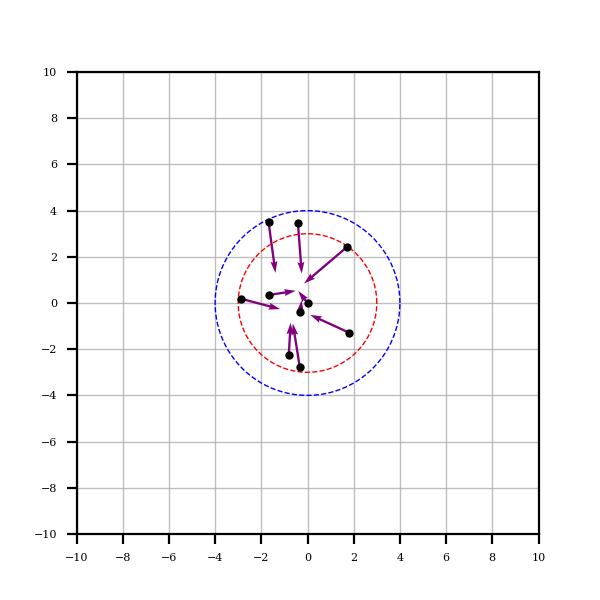

In [66]:
# create a small, simple, random swarm
b = mk_rand_swarm(10, grid=4.0)

# set `loc` to locate the initial swarm somewhere other than the origin
# set `goal` to give the swarm a goal
# set `kf` to a value >0 to include the direction vectors in the resultant
# set `grid` to reduce the size of the initial grid
# b = mk_rand_swarm(10, loc=-7.5, goal=-5.0, kd=1.0, grid=2.0)

# Compute the resultant vectors, including direction vectors and weightings

xv = np.subtract.outer(b[POS_X], b[POS_X])  # compute all pairs x-differences
yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # compute all pairs y-differences

# compute all pairwise vector magnitudes
mag = np.hypot(xv, yv)              # all pairs magnitudes

# compute the cohesion neighbours
coh_n = mag <= b[CF]               # test for those pairs of agents for which one is within the cohesion field of the other  
np.fill_diagonal(coh_n, False)     # no agent is a cohesion neighbour of itself
nr_coh_n = np.sum(coh_n, axis = 0) # number of cohesion neighbours

# compute the x-differences and y-differences for cohesion vectors
xv_coh = np.where(coh_n, xv, 0.0)
yv_coh = np.where(coh_n, yv, 0.0)

# compute the resultant cohesion vectors 
b[COH_X] = xv_coh.sum(axis=0)                       # sum the x-differences 
b[COH_Y] = yv_coh.sum(axis=0)                       # sum the y-differences
b[COH_X:COH_Y+1] /= np.maximum(nr_coh_n, 1)         # divide by the number of cohesion neighbours

# compute the repulsion neighbours
rep_n = mag <= b[RF]
np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
nr_rep_n = np.sum(rep_n, axis = 0) # number of repulsion neighbours

# compute the x-differences and y-differences for repulsion vectors
rscalar = mag / b[RF] - 1     # repulsion scaling factor
xv_rep = np.where(rep_n, xv * rscalar, 0.0)
yv_rep = np.where(rep_n, yv * rscalar, 0.0)

# compute the resultant repulsion vectors 
b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences
b[REP_X:REP_Y+1] /= np.maximum(nr_rep_n, 1)         # divide by the number of repulsion neighbours

# compute the direction vectors
b[DIR_X:DIR_Y+1] = b[GOAL_X:GOAL_Y+1] - b[POS_X:POS_Y+1]

# compute the resultant of the weighted cohesion, repulsion and direction vectors
b[RES_X:RES_Y+1] = b[KC] * b[COH_X:COH_Y+1] + b[KR] * b[REP_X:REP_Y+1] + b[KD] * b[DIR_X:DIR_Y+1]

# # normalise the resultant
# mag_res = np.hypot(b[RES_X], b[RES_Y])
# mag_res = np.where(mag_res != 0, mag_res, np.finfo('float64').eps)
# b[RES_X:RES_Y+1] /= mag_res

# plot the results
mk_vplot()
plot_field(b[CF, 0], 'b--', pos=(b[POS_X,0], b[POS_Y,0])) # draw the cohesion field of b[0]
plot_field(b[RF, 0], 'r--', pos=(b[POS_X,0], b[POS_Y,0])) # draw the repulsion field of b[0]
plt.plot(b[POS_X], b[POS_Y], 'ko', markersize=2)          # draw the agent points 
plot_vector(b[RES_X:RES_Y+1].T, b[POS_X:POS_Y+1].T, colors='purple')   # draw the resultant vectors for all agents

## A basic simulator

A simple swarm simulator can be developed by defining a `step()` function, along the lines that we have followed so far. The only additional requirement is to normalise the overall resultant vector for each agent and to apply a speed factor to the normalised vector to calculate the distance moved by each agent in a single unit of simulated time (a step). 

Note the normalised vector derived from $\vec{v}$ is $\hat{v}$, where $\hat{v} = \frac{\vec{v}}{\lVert\vec{v}\rVert}$, giving a vector that has the same direction as $\vec{v}$ but with magnitude $1.0$.

In [67]:
def step(b, *, speed=0.05):
    """
    Compute one step in the evolution of swarm `b`
    
    :param b: the array modelling the state of the swarm
    :param speed: the speed of each agent, i.e. the number of simulation distance units per simulation time unit (step), default 0.05.
    """

    xv = np.subtract.outer(b[POS_X], b[POS_X])  # compute all pairs x-differences
    yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # compute all pairs y-differences

    # compute all pairwise vector magnitudes
    mag = np.hypot(xv, yv)              # all pairs magnitudes

    # compute the cohesion neighbours
    coh_n = mag <= b[CF]               # test for those pairs of agents for which one is within the cohesion field of the other  
    np.fill_diagonal(coh_n, False)     # no agent is a cohesion neighbour of itself
    nr_coh_n = np.sum(coh_n, axis = 0) # number of cohesion neighbours of each agent

    # compute the x-differences and y-differences for cohesion vectors
    xv_coh = np.where(coh_n, xv, 0.0)
    yv_coh = np.where(coh_n, yv, 0.0)

    # compute the resultant cohesion vectors 
    b[COH_X] = xv_coh.sum(axis=0)                       # sum the x-differences 
    b[COH_Y] = yv_coh.sum(axis=0)                       # sum the y-differences
    b[COH_X:COH_Y+1] /= np.maximum(nr_coh_n, 1)         # divide by the number of cohesion neighbours

    # compute the repulsion neighbours
    rep_n = mag <= b[RF]               # test for those pairs of agents for which one is within the repulsion field of the other
    np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
    nr_rep_n = np.sum(rep_n, axis = 0) # number of repulsion neighbours of each agent

    # compute the x-differences and y-differences for repulsion vectors
    rscalar = mag / b[RF] - 1                           # repulsion scaling factor
    xv_rep = np.where(rep_n, xv * rscalar, 0.0)
    yv_rep = np.where(rep_n, yv * rscalar, 0.0)
    
    # compute the resultant repulsion vectors 
    b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
    b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences
    b[REP_X:REP_Y+1] /= np.maximum(nr_rep_n, 1)         # divide by the number of repulsion neighbours

    # compute the direction vectors
    b[DIR_X:DIR_Y+1] = b[GOAL_X:GOAL_Y+1] - b[POS_X:POS_Y+1]

    # compute the resultant of the weighted cohesion, repulsion and direction vectors
    b[RES_X:RES_Y+1] = b[KC] * b[COH_X:COH_Y+1] + b[KR] * b[REP_X:REP_Y+1] + b[KD] * b[DIR_X:DIR_Y+1]
        
    # normalise the resultant
    mag_res = np.hypot(b[RES_X], b[RES_Y])
    mag_res = np.where(mag_res != 0, mag_res, np.finfo('float64').eps)
    b[RES_X:RES_Y+1] /= mag_res


    # multiply resultant by factor for speed and update positions of agents
    b[RES_X:RES_Y+1] *= speed                            # scale normalised resultant vector by speed
    b[POS_X:POS_Y+1] += b[RES_X:RES_Y+1]                 # update positions of all agents
    
    return mag, coh_n, rep_n                             # useful to have these data structures available for use in other functions


Given a `step()` function, we can create a function, `run_simulation()`, to run a simulation of the `step()` function. The `run_simulation()` function is very simple. It takes a swarm as its first argument, creates a simple figure to record the positions of the swarm's agents, repeatedly runs the `step()` function, and updates the figure with the agents recorded at their new positions. The simplicity of the `run_simulation()` function derives from its use of `matplotlib.animation.FuncAnimation` which handles the periodic running of the `step()` function and the updating of the figure.

In [68]:
def run_simulation(b, *, step=step, **kwargs):
    """
    run a simulation of the `step()` function in a simple graphical environment
    
    :param b: the array modelling the state of the swarm
    :param step: the step function
    :param **kwargs: keyword arguments for the step function
    """
    fig, ax = plt.subplots(figsize=(4,4))                  # create a graph
    ax.set(xlim=(-10, 10), ylim=(-10, 10))                 # set the limits of the axes
    agent_data, = ax.plot(b[0], b[1], 'ko', markersize=2)  # plot the initial locations of the agents

    def simulate(i):
        """
        Ultra-simple simulation function  
        """
        step(b, **kwargs)                               # take a step
        agent_data.set_data(b[POS_X], b[POS_Y])         # plot the agents at their new locations
        
    return FuncAnimation(fig, simulate, interval=100)   # return a function that calls `simulate` every 100 ms and updates the figure

Now we can create a variety of small- to medium-sized swarms and observe their behaviour. Importantly, however, the use of Numpy's vectorised operations provides the basis of an efficient approach to the simulation of much larger swarms. This will be explored in more detail later. For now, you should create some simple swarms, using a variety of parameters, to see how they behave.

<IPython.core.display.Javascript object>


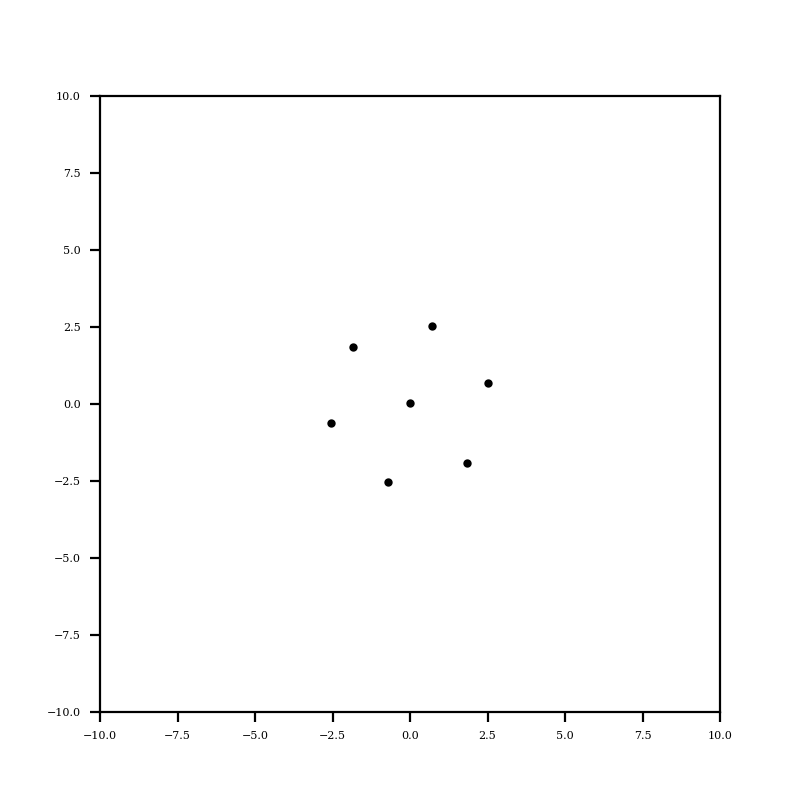

In [89]:
# create a swarm using some interesting parameters
# b = mk_rand_swarm(100, rf=4.0, cf=5.0, grid=4.0)
# b = mk_rand_swarm(100, kd=1.0, kr=4.0, loc=-7.0, grid=4.0)
# b = mk_rand_swarm(100, rf=1.0, cf=2.0, kr=15.0, grid=4.0)
# b = mk_rand_swarm(100, rf=3.0, cf=5.0, grid=10.0)
# b = mk_rand_swarm(100, rf=2.0, cf=5.0, kr=30.0, grid=6.0)
# b = mk_rand_swarm(7, loc=-7.5, kd=1.0, kr=30.0, grid=4.0)
b = mk_rand_swarm(7, loc=-7.5, kd=1.0, kr=20.0, grid=4.0)
sim = run_simulation(b, step=step)

We can make a preliminary stab at estimating the performance of our `step` algorithm by creating a random swarm of 1000 agents and using the `%timeit` magic function to see how long it takes to execute a step in the evolution of the swarm.

In [70]:
b = mk_rand_swarm(1000)
%timeit step(b)

45.9 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We can obtain a more detailed understanding of the performance of the code by using the `line_profiler`. You can install this for `anaconda` using `conda install line_profiler`.

In [71]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [72]:
b = mk_rand_swarm(2000)    # create a swarm of 2000 agents
%lprun -f step step(b)     # get a line-by-line breakdown of where the time is used

Notice that the bulk of the time (~40%) is spent in computing the pairwise distances between agents. The next most expensive operations are the computations of the x- and y-values for the repulsion vectors. There doesn't seem to be any obvious way of reducing the time taken by these operations (although the upper- or lower-triangle would suffice for the pairwise distances, it's not clear how to exploit this without losing the performance boost of vectorised operations).

## A revised repulsion scaling factor

### Background

The `step()` function is intended to implement the mathematical specification of swarm behaviour given in (Eliot, 2017). To paraphrase briefly this specification (ignoring obstacles for the moment) for a swarm, $S$, and agent, $b \in S$:

$$
v(b) = k_cv_c(b) + k_rv_r(b) + k_dv_d(b)
$$
where $k_c$, $k_r$, and $k_d$ are the weighting factors for the cohesion, repulsion and direction components of the resultant vector, respectively, and:

$$
v_c(b) = \frac{1}{\lvert n_c(b)\rvert} \sum_{b' \in n_c(b)}\vec{b b'}
$$

$$
v_r(b) = \frac{-1}{\lvert n_r(b)\rvert} \sum_{b' \in n_r(b)}\left(\left(1 - \frac{\lVert\vec{b b'}\rVert}{R_b}\right)\vec{b b'}\right)
$$

$$
v_d(b) = \vec{b g}
$$

where $n_c(b)$ and $n_r(b)$ are functions returning the sets of cohesion and repulsion neighbours of $b$, as follows:

$$
n_c(b) = \{b' \in S : b' \neq b \land \lVert\vec{b b'}\rVert <= C_b\}
$$

$$
n_r(b) = \{b' \in S : b' \neq b \land \lVert\vec{b b'}\rVert <= R_b\}
$$

and $g$ specifies the Cartesian coordinates of a position in the 2-D space of the swarm, known as the 'goal'. The implementation of `step()` follows this specification directly in the cases of of $v_c(b)$ and $v_d(b)$. The `step()` function implements a rewritten, but equivalent, specification of $v_r(b)$ , namely:

$$
v_r(b) = \frac{1}{\lvert n_r(b)\rvert} \sum_{b' \in n_r(b)}\left(\left(\frac{\lVert\vec{b b'}\rVert}{R_b} - 1\right)\vec{b b'}\right)
$$

### The problem

It is easy to explore the import of this specification for a pair of distinct agents, $b$ and $b'$, simply by focusing on the expression

$$
\left(\left(\frac{\lVert\vec{b b'}\rVert}{R_b} - 1\right)\vec{b b'}\right)
$$

Consider an agent $b_0$ at the origin with a repulsion field $R_{b_0}$ of $5.0$ and a second agent $b_1$ at $(4,3)$. The magnitude of the vector $\vec{b_0 b_1}$ is 5.0, so the magnitude of the resulting repulsion vector is $0$, as shown below:

<IPython.core.display.Javascript object>


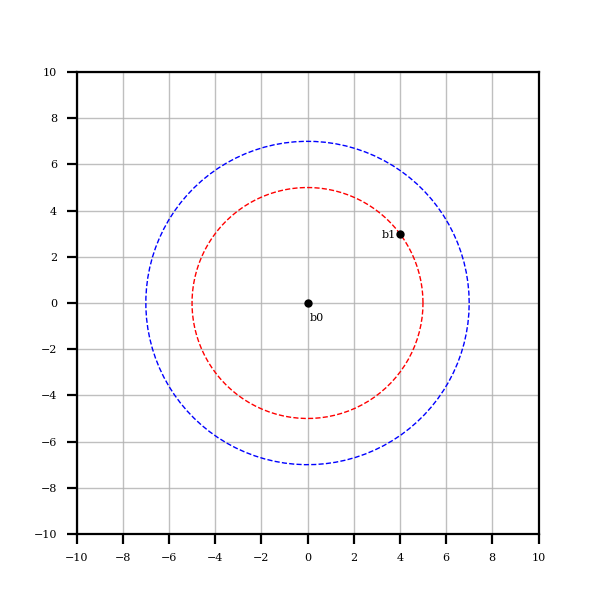

The magnitude of the vector b0b1 is 5.0
The magnitude of the repulsion vector is 0.0


In [73]:
b = mk_swarm([0., 4.], [0., 3.], cf=7.0, rf=5.0)

xv = np.subtract.outer(b[POS_X], b[POS_X])  # compute all pairs x-differences
yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # compute all pairs y-differences

# compute all pairwise vector magnitudes
mag = np.hypot(xv, yv)              # all pairs magnitudes

# compute the repulsion neighbours
rep_n = mag <= b[RF]
np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
nr_rep_n = np.sum(rep_n, axis = 0) # number of repulsion neighbours

# compute the x-differences  and y-differences for repulsion vectors
rscalar = mag / b[RF] - 1
xv_rep = np.where(rep_n, xv * rscalar, 0.0)
yv_rep = np.where(rep_n, yv * rscalar, 0.0)

# plot the results
mk_vplot()
plot_field(b[CF, 0], 'b--')                                           # draw the cohesion field of b[0]
plot_field(b[RF, 0], 'r--')                                           # draw the repulsion field of b[0]
plt.plot(b[POS_X], b[POS_Y], 'ko', markersize=2)                      # draw the agent points 
rep_v_0 = np.column_stack((xv_rep.T[0], yv_rep.T[0]))                 # get repulsion vectors for agent 0 - just for plotting            
plot_vector(rep_v_0, colors='red')                                    # draw the repulsion vector from b[0] to b[1]
plt.text(0.1, -0.8, 'b0')
plt.text(b[POS_X,1] - 0.8, b[POS_Y,1] - 0.2, 'b1')
print(f"The magnitude of the vector b0b1 is {mag[1, 0]}")
print(f"The magnitude of the repulsion vector is {np.hypot(xv_rep[1,0], yv_rep[1,0])}")

Now try changing the location of $b_1$ to (3, 2.25) in the code above. Run it and observe the effect. We now have a repulsion vector whose magnitude is 0.9375. Now move $b_1$ to (2, 1.5). Run and observe as before. The magnitude of the repulsion vector is now 1.25. But, from this point on, as $b_1$ moves closer to $b_0$, the magnitude of the repulsion vector grows *smaller*. Try $b_1$ at (1, 0.75). The magnitude of the repulsion vector is now back down to 0.9375. What about (0.5, 0.375)? Tha magnitude of the repulsion vector is 0.546875! In fact, the magnitude of the repulsion vector is at its maximum when the distance between $b$ and $b'$ is $\frac{R_b}{2}$ and *decreases* then, as the distance between the agents decreases. Surely, this is not how we expect the repulsion vector to behave?

### A proposed solution

An approach in which the magnitude of the repulsion vector continues to grow as an agent moves closer would seem to be preferable. There is a variety of possible ways to achieve this. A simple method is introduced here. The idea is to use the radius of the repulsion field in a linear scaling of the normalised vector between each agent pair, as follows:

$$
v_r(b) = \frac{1}{\lvert n_r(b)\rvert} \sum_{b' \in n_r(b)}\left(\left(\lVert\vec{b b'}\rVert - R_b\right)\widehat{b b'}\right)
$$

Remember that we only consider repulsion neighbours here. So, $\lVert\vec{b b'}\rVert \leq R_b$ and, therefore, $\lVert\vec{b b'}\rVert - R_b$ is either 0 or negative, and it becomes increasingly negative as the distance between the agents becomes smaller.


<IPython.core.display.Javascript object>


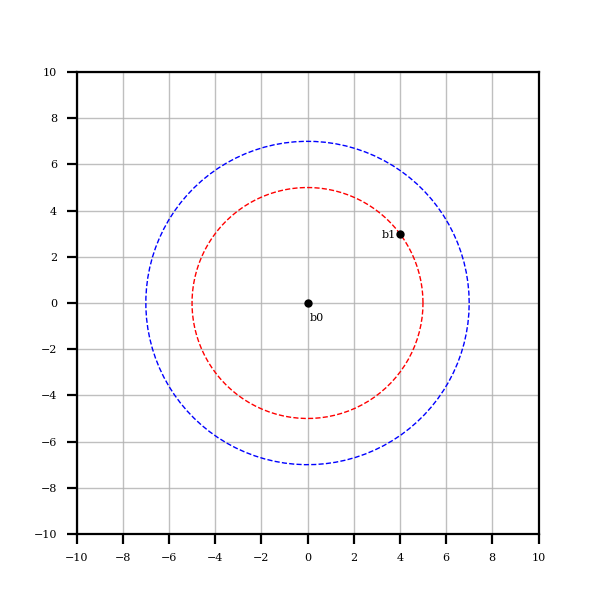

The magnitude of the vector b0b1 is 5.0
The magnitude of the repulsion vector is 0.0


In [74]:
b = mk_swarm([0.0, 4.0], [0.0, 3.0], cf=7.0, rf=5.0)

xv = np.subtract.outer(b[POS_X], b[POS_X])  # compute all pairs x-differences
yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # compute all pairs y-differences

# compute all pairwise vector magnitudes
mag = np.hypot(xv, yv)              # all pairs magnitudes

# compute the repulsion neighbours
rep_n = mag <= b[RF]
np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
nr_rep_n = np.sum(rep_n, axis = 0) # number of repulsion neighbours

# compute the x-differences and y-differences for repulsion vectors
mag_nz = mag != 0                                     
rep_n_and_mag_nz = np.logical_and(rep_n, mag_nz)    # repulsion neighbour and magnitude non-zero
rscalar = mag - b[RF]                             # repulsion scaling factor
xv_rep = np.where(rep_n_and_mag_nz, np.divide(xv * rscalar, mag, where = mag_nz), 0.) # ensure 0 if not repulsion neighbour or mag = 0
yv_rep = np.where(rep_n_and_mag_nz, np.divide(yv * rscalar, mag, where = mag_nz), 0.) # ensure 0 if not repulsion neighbour or mag = 0

# plot the results
mk_vplot()
plot_field(b[CF, 0], 'b--')                                           # draw the cohesion field of b[0]
plot_field(b[RF, 0], 'r--')                                           # draw the repulsion field of b[0]
plt.plot(b[POS_X], b[POS_Y], 'ko', markersize=2)                      # draw the agent points 
rep_v_0 = np.column_stack((xv_rep.T[0], yv_rep.T[0]))                 # get repulsion vectors for agent 0 - just for plotting            
plot_vector(rep_v_0, colors='red')                                    # draw the repulsion vector from b[0] to b[1]
plt.text(0.1, -0.8, 'b0')
plt.text(b[POS_X,1] - 0.8, b[POS_Y,1] - 0.2, 'b1')
print(f"The magnitude of the vector b0b1 is {mag[1, 0]}")
print(f"The magnitude of the repulsion vector is {np.hypot(xv_rep[1,0], yv_rep[1,0])}")

As before, try changing the location of $b_1$ to (3, 2.25), (2, 1.5), (1, 0.75), and (0.5, 0.375), and, in each case, observe the magnitude of the repulsion vector induced in $b_0$. This looks like a more sensible approach.

The program below illustrates the kind of resultant vectors generated using this new approach.

<IPython.core.display.Javascript object>


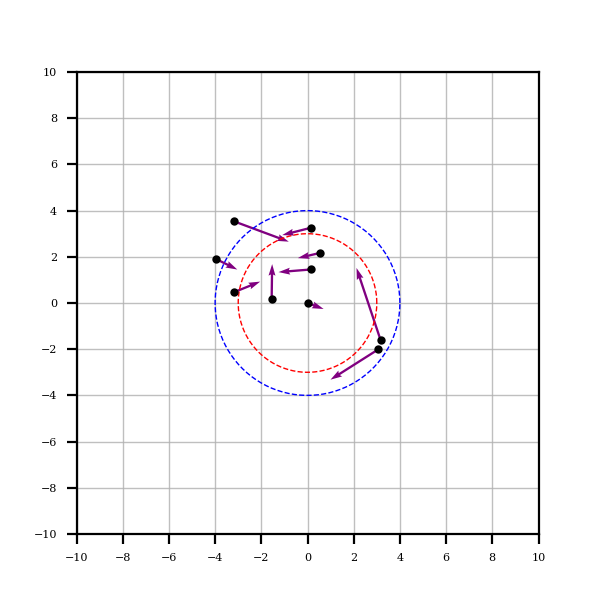

In [75]:
# create a small, simple, random swarm
b = mk_rand_swarm(10, grid=4.0)

# set `loc` to locate the initial swarm somewhere other than the origin
# set `goal` to give the swarm a goal
# set `kf` to a value >0 to include the direction vectors in the resultant
# set `grid` to reduce the size of the initial grid
# b = mk_rand_swarm(10, loc=-7.5, goal=-5.0, kd=1.0, grid=2.0)

# Compute the resultant vectors, including direction vectors and weightings

xv = np.subtract.outer(b[POS_X], b[POS_X])  # compute all pairs x-differences
yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # compute all pairs y-differences

# compute all pairwise vector magnitudes
mag = np.hypot(xv, yv)              # all pairs magnitudes

# compute the cohesion neighbours
coh_n = mag <= b[CF]               # test for those pairs of agents for which one is within the cohesion field of the other  
np.fill_diagonal(coh_n, False)     # no agent is a cohesion neighbour of itself
nr_coh_n = np.sum(coh_n, axis = 0) # number of cohesion neighbours

# compute the x-differences and y-differences for cohesion vectors
xv_coh = np.where(coh_n, xv, 0.0)
yv_coh = np.where(coh_n, yv, 0.0)

# compute the resultant cohesion vectors 
b[COH_X] = xv_coh.sum(axis=0)                       # sum the x-differences 
b[COH_Y] = yv_coh.sum(axis=0)                       # sum the y-differences
b[COH_X:COH_Y+1] /= np.maximum(nr_coh_n, 1)         # divide by the number of cohesion neighbours

# compute the repulsion neighbours
rep_n = mag <= b[RF]
np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
nr_rep_n = np.sum(rep_n, axis = 0) # number of repulsion neighbours

# compute the x-differences and y-differences for repulsion vectors
eps = np.finfo('float64').eps
mag_nz = np.where(mag != 0, mag, eps)                                  
rscalar = mag - b[RF]               
xv_rep = np.full_like(xv, 0.)
yv_rep = np.full_like(yv, 0.)
xv_rep[rep_n] = xv[rep_n] / mag_nz[rep_n] * rscalar[rep_n] # scale the normalised x-values
yv_rep[rep_n] = yv[rep_n] / mag_nz[rep_n] * rscalar[rep_n] # scale the normalised y-values

# compute the resultant repulsion vectors 
b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences
b[REP_X:REP_Y+1] /= np.maximum(nr_rep_n, 1)            # divide by the number of repulsion neighbours

# compute the direction vectors
b[DIR_X:DIR_Y+1] = b[GOAL_X:GOAL_Y+1] - b[POS_X:POS_Y+1]

# compute the resultant of the weighted cohesion, repulsion and direction vectors
b[RES_X:RES_Y+1] = b[KC] * b[COH_X:COH_Y+1] + b[KR] * b[REP_X:REP_Y+1] + b[KD] * b[DIR_X:DIR_Y+1]

# compute the resultant magnitudes and normalise the resultant
# mag_res = np.hypot(b[RES_X], b[RES_Y])
# mag_res = np.where(mag_res != 0, mag_res, eps)
# b[RES_X:RES_Y+1] /= mag_res

# plot the results
mk_vplot()
plot_field(b[CF, 0], 'b--', pos=(b[POS_X,0], b[POS_Y,0])) # draw the cohesion field of b[0]
plot_field(b[RF, 0], 'r--', pos=(b[POS_X,0], b[POS_Y,0])) # draw the repulsion field of b[0]
plt.plot(b[POS_X], b[POS_Y], 'ko', markersize=2)          # draw the agent points 
plot_vector(b[RES_X:RES_Y+1].T, b[POS_X:POS_Y+1].T, colors='purple')       # draw the resultant vectors for all agents

It is also worth experimenting with variations on this, for example, using constant, quadratic, cubic or exponential factors. Two possibilities that are worth considering are:

*Inverse square*
$$
v_r(b) = \frac{1}{\big\lvert n_r(b)\big\rvert} \sum_{b' \in n_r(b)}\left(-R_b \cdot \lVert\vec{b b'}\rVert^{-2} \cdot \widehat{b b'}\right)
$$

*Inverse exponential*
$$
v_r(b) = \frac{1}{\big\lvert n_r(b)\big\rvert} \sum_{b' \in n_r(b)}\left(-R_b \cdot e^{-\lVert\vec{b b'}\rVert} \cdot \widehat{b b'}\right)
$$

The code below implements a step function, `d_step()`, that implements all three approaches. Try plugging this into some simulations.

In [76]:
def d_step(b, *, scaling='linear', exp_rate=0.2, speed=0.05):
    """
    Compute one step in the evolution of swarm `b`
    
    :param b: the array modelling the state of the swarm
    :param scaling: choose 'linear', 'quadratic', or 'exponential' scaling of repulsion vectors
    :param exp_rate: rate of scaling in 'exponential' case
    :param speed: the speed of each agent, i.e. the number of simulation distance units per simulation time unit (step)
    """
    xv = np.subtract.outer(b[POS_X], b[POS_X])  # all pairs x-differences
    yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # all pairs y-differences

    # compute all pairwise vector magnitudes
    mag = np.hypot(xv, yv)              # all pairs magnitudes
    
    # compute the cohesion neighbours
    coh_n = mag <= b[CF]
    np.fill_diagonal(coh_n, False)     # no agent is a cohesion neighbour of itself
    nr_coh_n = np.sum(coh_n, axis = 0) # number of cohesion neighbours

    # compute the x-differences and y-differences for cohesion vectors
    xv_coh = np.where(coh_n, xv, 0.0)
    yv_coh = np.where(coh_n, yv, 0.0)

    # compute the cohesion vectors 
    b[COH_X] = xv_coh.sum(axis=0)                       # sum the x-differences 
    b[COH_Y] = yv_coh.sum(axis=0)                       # sum the y-differences
    b[COH_X:COH_Y+1] /= np.maximum(nr_coh_n, 1)         # divide by the number of cohesion neighbours

    # compute the repulsion neighbours
    rep_n = mag <= b[RF]
    np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
    nr_rep_n = np.sum(rep_n, axis = 0) # number of repulsion neighbours

    # compute the x-differences and y-differences for repulsion vectors
    eps = np.finfo('float64').eps
    mag_nz = np.where(mag != 0, mag, eps)                                  
    if scaling == 'linear':                             # repulsion scaling factor
        rscalar = mag[rep_n] - (rep_n * -b[RF])[rep_n]              
    elif scaling == 'quadratic':
        rscalar = (rep_n * -b[RF])[rep_n] * (mag_nz[rep_n] ** (-2))
    elif scaling == 'exponential':
        rscalar = (rep_n * -b[RF])[rep_n] * (np.e ** (-mag[rep_n] * exp_rate))
    else:
        assert(False)
    xv_rep = np.full_like(xv, 0.)
    yv_rep = np.full_like(yv, 0.)
    xv_rep[rep_n] = xv[rep_n] / mag_nz[rep_n] * rscalar # scale the normalised x-values
    yv_rep[rep_n] = yv[rep_n] / mag_nz[rep_n] * rscalar # scale the normalised y-values

    # compute the resultant repulsion vectors 
    b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
    b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences
    b[REP_X:REP_Y+1] /= np.maximum(nr_rep_n, 1)         # divide by the number of repulsion neighbours
    
    # compute the direction vectors
    b[DIR_X:DIR_Y+1] = b[GOAL_X:GOAL_Y+1] - b[POS_X:POS_Y+1]

    # compute the resultant of the cohesion, repulsion and direction vectors
    b[RES_X:RES_Y+1] = b[KC] * b[COH_X:COH_Y+1] + b[KR] * b[REP_X:REP_Y+1] + b[KD] * b[DIR_X:DIR_Y+1]
                  
    # compute the resultant magnitudes and normalise the resultant
    mag_res = np.hypot(b[RES_X], b[RES_Y])
    mag_res = np.where(mag_res != 0, mag_res, eps)
    b[RES_X:RES_Y+1] /= mag_res

    # multiply resultant by factor for speed and update positions of agents
    b[RES_X:RES_Y+1] *= speed                               # distance units per time unit
    b[POS_X:POS_Y+1] += b[RES_X:RES_Y+1]                    # update positions
    
    return mag, coh_n, rep_n                                # helpful later in the calculation of metrics


<IPython.core.display.Javascript object>


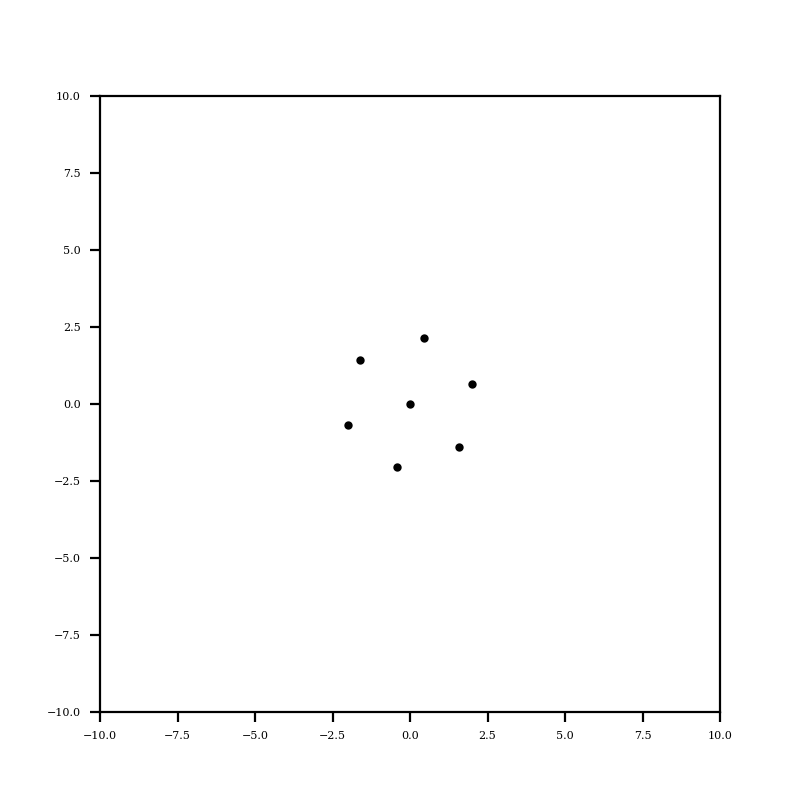

In [88]:
# create a swarm using some interesting parameters
# b = mk_rand_swarm(100, rf=4.0, cf=5.0, kr=3.0, grid=4.0)
# b = mk_rand_swarm(100, kd=1.0, kr=4.0, loc=-7.0, grid=4.0)
# b = mk_rand_swarm(100, rf=1.0, cf=2.0, kr=15.0, grid=4.0)
# b = mk_rand_swarm(100, rf=3.0, cf=5.0, kr=20.0, grid=10.0)
# b = mk_rand_swarm(100, rf=2.0, cf=5.0, kr=30.0, grid=6.0)
b = mk_rand_swarm(7, rf=4.0, cf=5.0, loc=-7.5, kr=10.0, kd=1.0, grid=0.1)
sim = run_simulation(b, step=d_step, scaling='quadratic')

The new `d_step()` function is about 5% to 40% slower than the previous `step()` function, depending on the approach to scaling the repulsion magnitude. This seems like a price worth paying.

In [78]:
b = mk_rand_swarm(1000)
%timeit d_step(b, scaling='quadratic')

67.4 ms ± 5.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [79]:
b = mk_rand_swarm(2000)                             # create a swarm of 2000 agents
%lprun -f d_step d_step(b, scaling='quadratic')     # get a line-by-line breakdown of where the time is used

## Metrics

### Distance metric

#### Definition

The essential features of the distance metric for swarms, presented in (Eliot et al. 2018), can be summarised as follows:

$$
\psi_d(S) = \mu_d(S) \pm \sigma_d(S)
$$

where $\mu_d(S)$ is the mean distance over all agents $b \in S$, between $b$ and its cohesion neighbours, given by:

$$
\mu_d(S) = \frac{\sum_{b \in S} \sum_{b' \in n_c(b)}\, \lVert\vec{b_0 b_1}\rVert}{\sum_{b \in S}\,\big\lvert n_c(b)\big\rvert}
$$

and $\sigma_d(S)$ is the standard deviation from the mean:

$$
\sigma_d(S) = \sqrt{\frac{\sum_{b \in S} \sum_{b' \in n_c(b)}\, \left(\lVert\vec{b b'}\rVert - \mu_d(S)\right)^2}{\sum_{b \in S}\,\big\lvert n_c(b)\big\rvert}}
$$

#### Implementation

Let us construct a small swarm, take a simulation step, and examine the data structures available to us for implementing $\mu_d(S)$ and $\sigma_d(S)$:

In [80]:
b = mk_rand_swarm(5, grid=4.0)
mag, coh_n, _ = d_step(b)
mag, coh_n

(array([[0.        , 3.02859659, 2.11170717, 3.67773435, 4.90782757],
        [3.02859659, 0.        , 5.11372658, 6.36225081, 2.44914532],
        [2.11170717, 5.11372658, 0.        , 2.78805739, 6.98901473],
        [3.67773435, 6.36225081, 2.78805739, 0.        , 7.44042979],
        [4.90782757, 2.44914532, 6.98901473, 7.44042979, 0.        ]]),
 array([[False,  True,  True,  True, False],
        [ True, False, False, False,  True],
        [ True, False, False,  True, False],
        [ True, False,  True, False, False],
        [False,  True, False, False, False]]))

We can see that `mag` represents all pairwise distances between agents and `coh_n` represents the cohesion neighbours of all agents. We can think of `coh_n` as a mask that can be applied to `mag` to obtain all, and only, those distances between cohesion neighbours. For example, `mag[coh_n]` gives

In [81]:
mag[coh_n]

array([3.02859659, 2.11170717, 3.67773435, 3.02859659, 2.44914532,
       2.11170717, 2.78805739, 3.67773435, 2.78805739, 2.44914532])

This leads to a simple implementation of a function  for $\mu_d$ and $\sigma_d$ (note it's convenient to compute the mean and standard deviation together):

In [82]:
def mu_sigma_d(mag, coh_n):
    """
    Compute the mean and SD of the distance over all agents between an agent and its cohesion neighbours.
    
    :param mag: an array giving all pairwise distances between agents
    :param coh_n: an array giving the cohesion neighbours of all agents
    """
    mu_d = np.sum(mag[coh_n]) / np.sum(coh_n)
    sigma_d = np.sum((mag[coh_n] - mu_d) ** 2) / np.sum(coh_n)
    return mu_d, sigma_d

We can use the distance metric to explore the evolution of a swarm over a number of simulation steps.

<IPython.core.display.Javascript object>


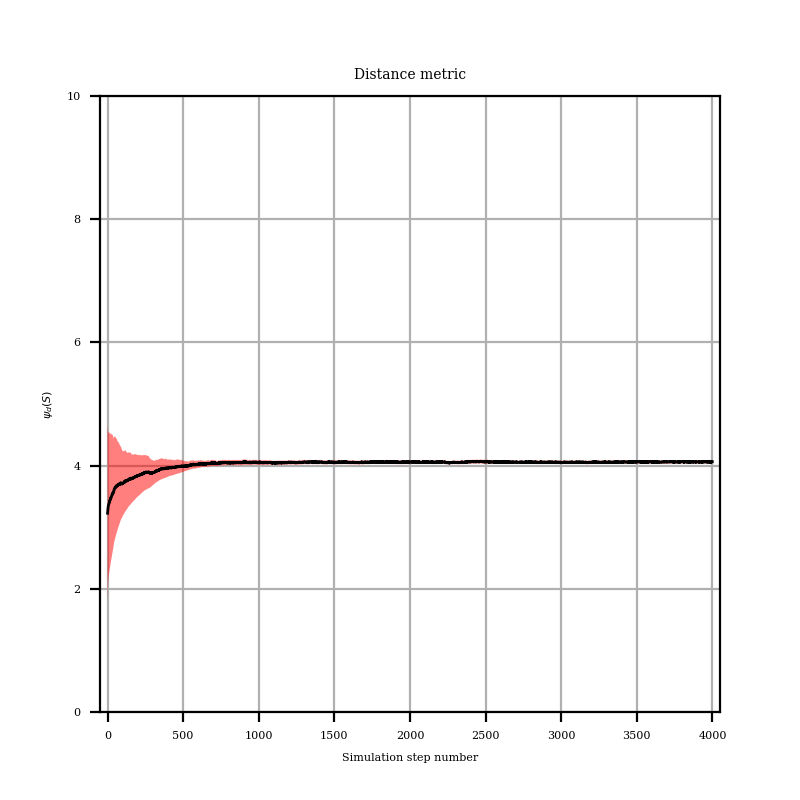

In [83]:
b = mk_rand_swarm(200, rf=4.0, cf=5.0, kr=20.0, grid=10.0)                # create a swarm
# b = mk_rand_swarm(5, kr=100.0, grid=4.0)
# b = mk_rand_swarm(1000, rf=7.0, cf=8.0, kr=100.0, grid=1.0)
# b = mk_rand_swarm(7, cf=7.0, rf=8.0, loc=-7.5, kr=50.0, kd=1.0, grid=4.0)
n_steps = 4000                                                              # set the number of simulation steps to do
step_ids = [i for i in range(n_steps)]                                      # create a list of step numbers
mu = []                                                                     # create a list for the mean at each step 
sigma = []                                                                  # create a list for the SD at each step
for i in range(n_steps):
    mag, coh_n, _ = d_step(b, scaling='quadratic', speed=0.2)             # take a step
    m, s = mu_sigma_d(mag, coh_n)                                           # compute the mean and SD
    mu += [m]                                                               # add to lists
    sigma += [s]
step_ids = np.array(step_ids)                                               # convert lists to np arrays for easier plotting
mu = np.array(mu)
sigma = np.array(sigma)
fig, ax = plt.subplots(figsize=(4,4))                                       # create a graph
ax.set(xlim=(-50, n_steps+50), ylim=(0, 10))                                # set the limits of the axes
ax.set_title('Distance metric')
ax.set_xlabel('Simulation step number')
ax.set_ylabel('$\psi_d(S)$')
ax.grid(True)                                                               # show a grid
ax.plot(step_ids, mu, 'k-')                                                 # plot the mean
ax.fill_between(step_ids, mu + sigma, mu - sigma, facecolor='red', alpha=0.5)   # plot the standard deviation

It can be informative to observe a simulation of a swarm whose behaviour has been investigated using the distance metric.

<IPython.core.display.Javascript object>


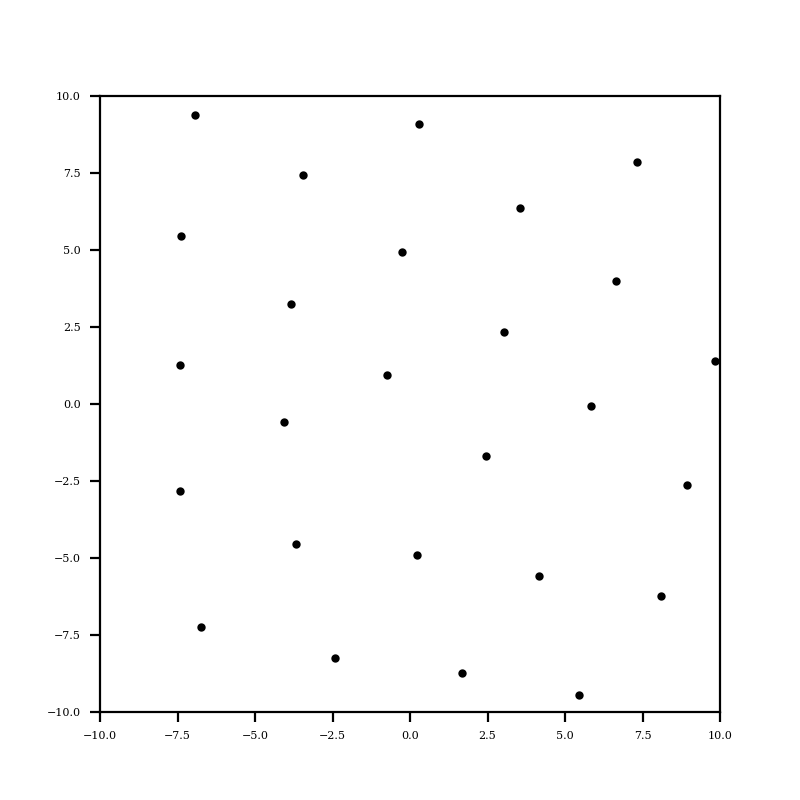

In [84]:
# b = mk_rand_swarm(200, rf=7.0, cf=8.0, kr=30.0, grid=20.0)
# b = mk_rand_swarm(200, rf=7.0, cf=8.0, kr=30.0, grid=10.0)
# b = mk_rand_swarm(200, rf=7.0, cf=8.0, kr=15.0, kd=1.0, grid=20.0)
# b = mk_rand_swarm(200, rf=7.0, cf=8.0, kr=100.0, grid=10.0)
# b = mk_rand_swarm(7, cf=5.0, kr=5.0, grid=4.0)
# b = mk_rand_swarm(36, loc=-7.5, kd=1.0, kr=30.0, grid=20.0)
sim = run_simulation(b, step=d_step, scaling='quadratic', speed=0.2)

### Cohesion/Repulsion metric

#### Definition

The essential features of the cohesion/repulsion metric for swarms, adapted from (Eliot et al. 2018), can be summarised as follows:

$$
\psi_p(S) = \mu_p(S) \pm \sigma_p(S)
$$

where $\mu_p(S)$ is the mean of the adjusted magnitude values of the weighted cohesion/repulsion vectors of all agents, induced by their cohesion/repulsion neighbours. For each cohesion/repulsion vector, a positive value is derived from the magnitude of the vector if the cohesion component of the
vector dominates, but a negative value is derived if the repulsion component dominates.

We define some helper functions, $v_{cr}$ and $P$, to 
aid the specifications of $\mu_p$ and $\sigma_p$:

$$
v_{cr}(b) = k_c v_c(b) + k_r v_r(b)
$$

$$
P(b) = \left\{ \begin{array}{ll}
                \lVert v_{cr}(b) \rVert & \quad k_c v_c(b) > k_r v_r(b) \\
                -\lVert v_{cr}(b) \rVert & \quad \mathrm{otherwise}
              \end{array}
       \right.
$$

$v_{cr}(b)$ gives the weighted cohesion/repulsion vector for $b$ and $P(b)$ gives the value derived from the magnitude of this vector. Now we can define the mean and standard deviation.

$$
\mu_p(S) = \frac{\sum_{b \in S} P(b)}{D}
$$

and $\sigma_p(S)$ is the standard deviation from the mean:

$$
\sigma_p(S) = \sqrt{\frac{\sum_{b \in S}\, (P(b) - \mu_p(S))^2}{D}}
$$

We still need to consider the definition of the denominator, $D$, here. (Eliot et al. 2018) defines $D$ like this:

$$
D = \sum_{b \in S}\, \big\lvert n_c(b) \big\rvert + \big\lvert n_r(b) \big\rvert
$$

This seems to me to be over-counting agents. Remember that each agent $b \in S$ has at most one cohesion/repulsion vector as defined above. This has been scaled already by the reciprocal of the number of its cohesion and repulsion neighbours (see the definitions of $v_c(b)$ and $v_r(b)$ earlier). In calculating $\mu_p(S)$ and $\sigma_p(S)$, we should be dividing by at most $\lvert S \rvert$ but the value of $D$, as defined above, may be as big as $2(\lvert S\rvert^2 - \lvert S\rvert)$, clearly too big!. It might be argued that even $\lvert S \rvert$ may be too big, since $S$ may include agents that are isolated and not participating in the cohesion/repulsion structure of the swarm and, therefore, should not be counted. In this case, we could define $D$ as

$$
D = \bigg\lvert \bigcup_{b \in S} (n_c(b) \cup n_r(b)) \bigg\rvert
$$

I think it's reasonable to consider that the cohesion/repulsion structure is a property of the whole swarm $S$, whether or not it contains isolated agents, and, in the following, I take $D$ to be

$$
D = \lvert S \rvert
$$

#### Implementation

Once a simulation step has been executed, the array `b`, modelling the swarm, has rows `b[COH_X:COH_Y+1]` and `b[REP_X:REP_Y+1]` that contain the x- and y-values of the resultant cohesion and repulsion vector, respectively, of every agent in the swarm. Given these, it is straighforward to construct a function for $\mu_p$ and $\sigma_p$ that follows the equations above:

In [85]:
def mu_sigma_p(b):
    vcr = b[KC] * b[COH_X:COH_Y+1] + b[KR] * b[REP_X:REP_Y+1]       # the weighted cohesion/repulsion vector of every agent
    vcr_mag = np.hypot(vcr[0], vcr[1])                              # the magnitude of the weighted cohesion/repulsion vector of every agent
    vc_mag = b[KC] * np.hypot(b[COH_X], b[COH_Y])                   # the magnitude of the cohesion component of the cohesion/repulsion vector
    vr_mag = b[KR] * np.hypot(b[REP_X], b[REP_Y])                   # the magnitude of the repulsion component of the cohesion/repulsion vector                 
    P = np.where(vc_mag > vr_mag, vcr_mag, -vcr_mag)                # the implementation of P as defined
    n_agents = b.shape[1]                                           # the total number of agents in the swarm
    mu_p = np.sum(P) / n_agents                                     # the mean 
    sigma_p = np.sqrt(np.sum((P - mu_p) ** 2) / n_agents)           # the standard deviation
    return mu_p, sigma_p

We can use the cohesion/repulsion metric to explore the evolution of a swarm over a number of simulation steps.

<IPython.core.display.Javascript object>


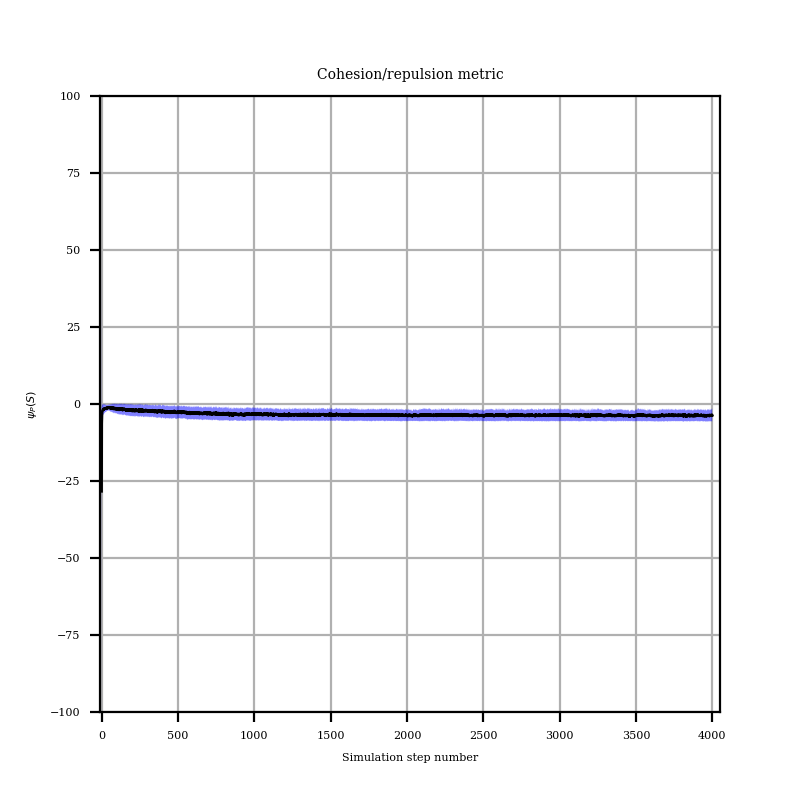

In [86]:
# b = mk_rand_swarm(200, rf=7.0, cf=8.0, kr=100.0, grid=200.0)                          # create a swarm
# b = mk_rand_swarm(1000, rf=2.0, cf=8.0, kr=100.0, grid=1.0)
# b = mk_rand_swarm(200, rf=7.0, cf=8.0, kr=5.0, grid=10.0)
# b = mk_rand_swarm(7, cf=7.0, rf=8.0, loc=-7.5, kr=50.0, kd=1.0, grid=4.0)
b = mk_rand_swarm(200, rf=4.0,cf=5.0, kr=20.0, grid=10)
n_steps = 4000                                                                          # set the number of simulation steps to do
step_ids = [i for i in range(n_steps)]                                                  # list of step numbers
mu_p = []                                                                               # create a list for the mean at each step
sigma_p = []                                                                            # create a list for the SD at each step
for i in range(n_steps):                                                                
    d_step(b, scaling='quadratic', speed=0.2)                                           # take a step
    m, s = mu_sigma_p(b)                                                                # get mean and SD
    mu_p += [m]                                                                         # add to lists
    sigma_p += [s]
step_ids = np.array(step_ids)                                                           # convert lists to np arrays for easier plotting
mu_p = np.array(mu_p)
sigma_p = np.array(sigma_p)
fig, ax = plt.subplots(figsize=(4,4))                                                   # create a graph
ax.set(xlim=(-10, n_steps+50), ylim=(-100, 100))                                        # set the properties of the axes
ax.set_title('Cohesion/repulsion metric')
ax.set_xlabel('Simulation step number')
ax.set_ylabel('$\psi_P(S)$')
ax.grid(True)                                                                           # show a grid
ax.plot(step_ids, mu_p, 'k-')                                                           # plot the mean
ax.fill_between(step_ids, mu_p + sigma_p, mu_p - sigma_p, facecolor='blue', alpha=0.5)  # plot the standard deviation

We can look at a simulation of (part of) the swarm after it's stabilised. 

<IPython.core.display.Javascript object>


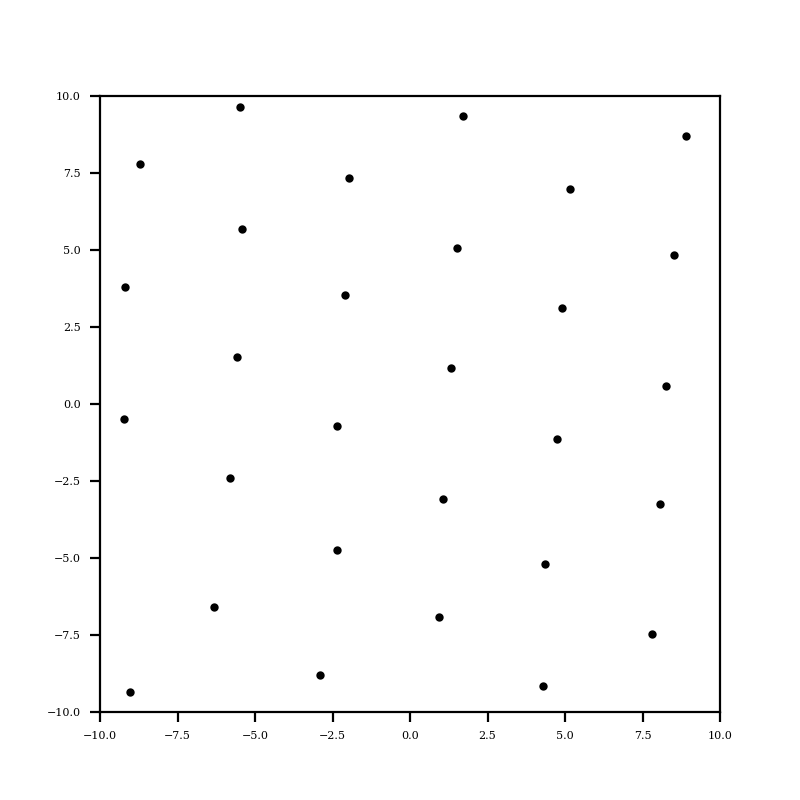

In [87]:
sim = run_simulation(b, step=d_step, scaling='quadratic', speed=0.2)

## Conclusions and further work

This notebook describes a very basic swarm simulator that has been implemented using Numpy and Matplotlib. The performance of the simulator seems quite promising. We need to attempt to validate this approach be comparing the results of simulations with those generated by PySwarm. We could then extend the approach to the other algorithms described in (Eliot, 2017) and, following that, could look to implement new algorithms, in particular those involving swarms with heterogeneous field values.